To run this program you have two options: upload a single czi image (preferred), or upload a fixed size square MT-Channel png/jpg (eg. 120x120 image). The only time when you should upload a single czi file is if the image is already zoomed into the area that you want to measure with this program with the nuclei of interest in the center. Otherwise, passing in an entire muscle image will cause issues with miscellaneous nuclei above and below the muscle that will be detected. To upload the image(s), simply run the corresponding loading code chunk below based on the image type you are choosing.

In [ ]:
!pip install aicsimageio
!pip install aicspylibczi
import numpy as np
from keras.preprocessing import image
import keras.utils as ut
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image, ImageDraw
from skimage.measure import label
from aicsimageio import AICSImage
from aicsimageio.readers import CziReader
import os
import pandas as pd
from scipy.ndimage import binary_dilation, binary_fill_holes
from scipy import ndimage as ndi
from skimage.feature import peak_local_max


  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
dfo = '/content/Concentric Circle Data.xlsx'

## Helper Functions

In [ ]:
def crop_black_border(image):
  # remove the black border
  row_max = image.max(axis = 1)
  row_ind = np.where(row_max>0)[0]
  col_max = image.max(axis = 0)
  col_ind = np.where(col_max>0)[0]
  return image[row_ind[0] : row_ind[-1]+1, col_ind[0] : col_ind[-1]+1]

def OtsuTwoLevelThreshold(th_high, th_low):
  plt.figure(figsize = (10,10))
  im_o = micro_im.copy()
  im_o[im_o > th_high] = 0
  im_o[im_o < th_low] = 0

  plt.subplot(121)
  plt.title('Input')
  plt.imshow(micro_im, cmap = 'gray')

  plt.subplot(122)
  plt.title('Output')
  plt.imshow(im_o, cmap = 'gray')
  print('Selected Param: th = (%d, %d)' % (th_high, th_low))
  return

def imAdjust(I, thres=[1,99]):
    # compute percentile: remove too big or too small values
    I_low, I_high = np.percentile(I.reshape(-1), thres)
    # thresholding
    I[I > I_high] = I_high
    I[I < I_low] = I_low
    # scale to 0-1
    I = (I.astype(float)- I_low)/ (I_high-I_low)
    # convert it to uint8
    I = (I * 255).astype(np.uint8)
    return I

## Loading czi images for nuclei detection

To load czi images into this code, in your "MyDrive" of your google drive, create a folder called "Concentric_Data" (if you haven't done so already). Then for each experiment/folder of images you want to analyze, upload the folder containing those czi images to "Concentric_Data". Then in the code below, change the genotype_name variable to the name of the folder you uploaded to "Concentric_Data". Spelling and capitalization matter.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_directory = '/content/drive/MyDrive/Concentric_Data'

genotype_name = 'Concentric circle'
def read_and_store_images(sub_folder):
    folder_path = os.path.join(base_directory, sub_folder)
    micro = []
    nuclei = []
    name = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.czi'):
            file_path = os.path.join(folder_path, filename)
            img = AICSImage(file_path)
            nuclei_im = img.get_image_data("ZYX", C=1)
            micro_im = img.get_image_data("ZYX", C=0)

            nuclei_im_max = np.max(nuclei_im, axis=0)
            micro_im_max = np.max(micro_im, axis=0)

            shape = nuclei_im_max.shape
            nuclei_im_max = cv2.rotate(nuclei_im_max, cv2.ROTATE_90_COUNTERCLOCKWISE)
            micro_im_max = cv2.rotate(micro_im_max, cv2.ROTATE_90_COUNTERCLOCKWISE)
            name.append(filename.rstrip('.czi'))
            micro.append(micro_im_max)
            nuclei.append(nuclei_im_max)
    return micro, nuclei, name

micro_im, nuclei_im, file_name = read_and_store_images(genotype_name)

Mounted at /content/drive


## Loading single MT channel image jpg/png

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_directory = '/content/drive/MyDrive'

def load_im(sub_folder):
  folder_path = os.path.join(base_directory, sub_folder)
  micro = []
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    nuclei_im = ut.load_img('/content/C3-MAX_VL3 4.3-1.jpg', grayscale=True)
    micro_im = ut.load_img(file_path, grayscale=True)

    nuclei_im = ut.img_to_array(nuclei_im, dtype='uint8')
    micro_im = ut.img_to_array(micro_im, dtype='uint8')

    nuclei_im = nuclei_im[:,:,0]
    micro_im = micro_im[:,:,0]

    nuclei_im = crop_black_border(nuclei_im)
    micro_im = crop_black_border(micro_im)
    if micro_im.shape[0] != 80 or micro_im.shape[1] != 80:
      print(file_path)
    micro.append(micro_im)
  return micro

#Change name in parenthesis to the name of folder on google drive
micro_im = load_im('folder name')

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/folder name'

## Visualizing each loaded MT-channel image

uint8


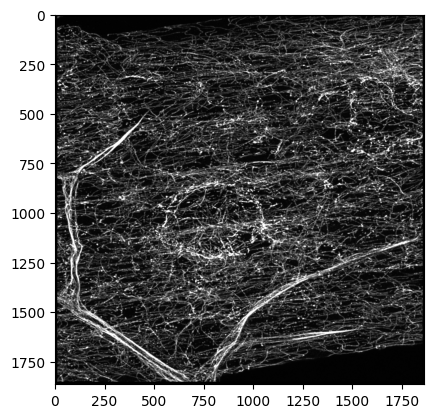

uint8


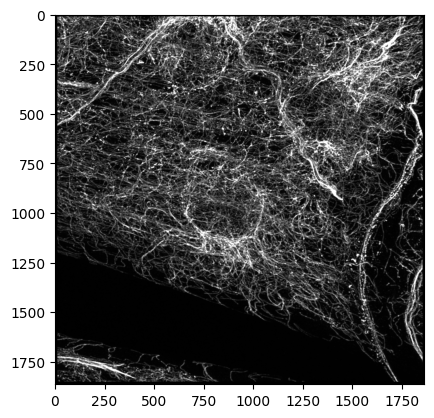

uint8


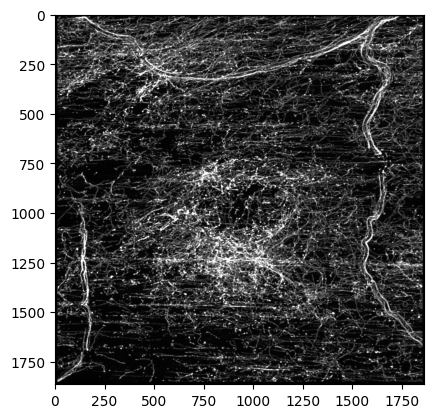

uint8


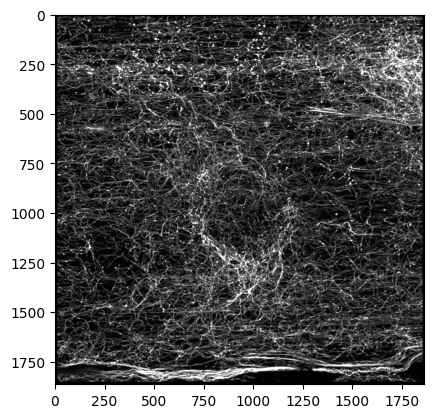

uint8


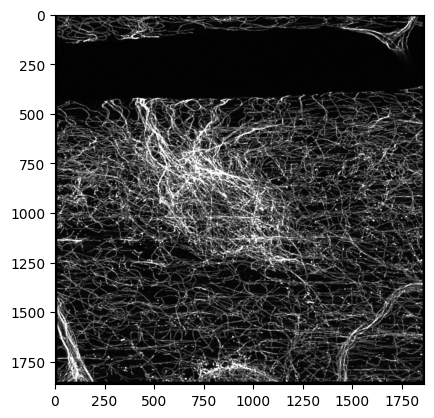

uint8


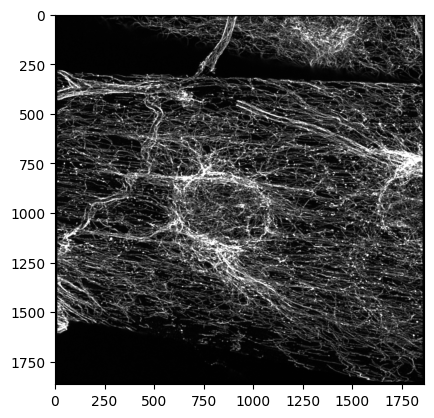

In [ ]:
for im in micro_im:
  im_adjust = imAdjust(im)
  plt.imshow(im_adjust, cmap = 'gray')
  print(im_adjust.dtype)
  plt.show()

## Automatically Calculating Nuclei Center for Airyscan only

The following code will loop through all the input images and(hopefully) automatically calculate the center of the nuclei. The calculated centers will be displayed for human check. Of course, there is no algorithm that works 100%, so if it makes a mistake, you can always manually type in the x,y coordinates of the nuclei centers by uncommenting the last two lines of code below (simply delete the # sign for uncommenting a line of code)

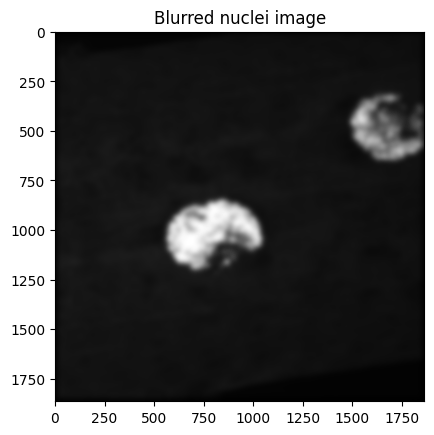

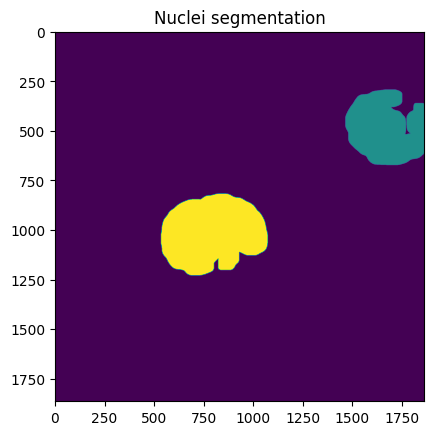

[[1023  706]
 [ 983  831]
 [ 499 1615]]


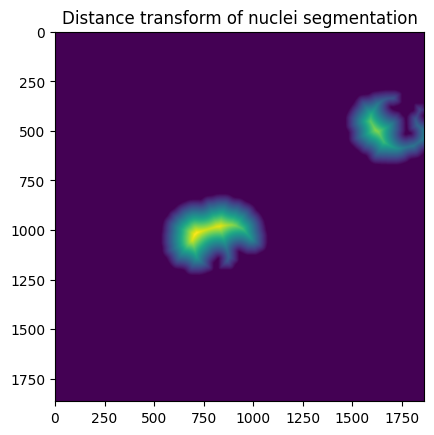

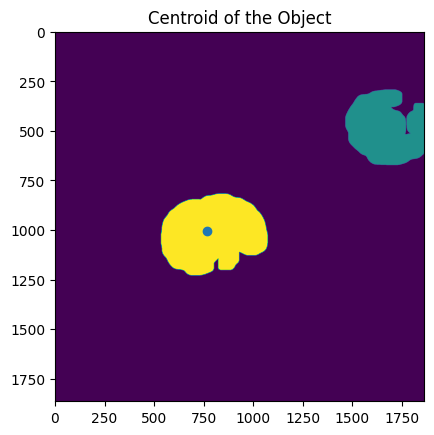

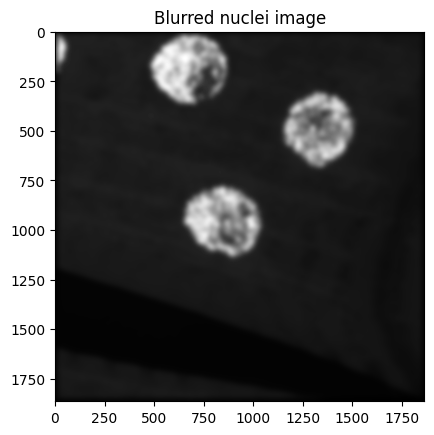

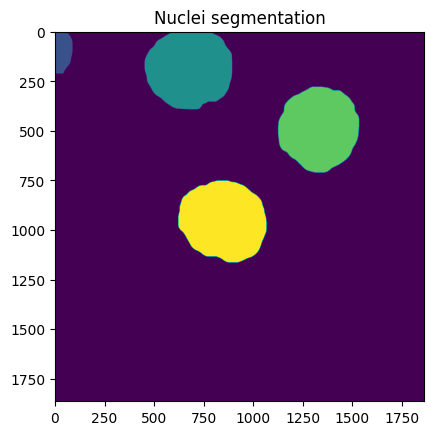

[[ 486 1332]
 [ 186  669]
 [ 947  848]
 [ 948  854]]


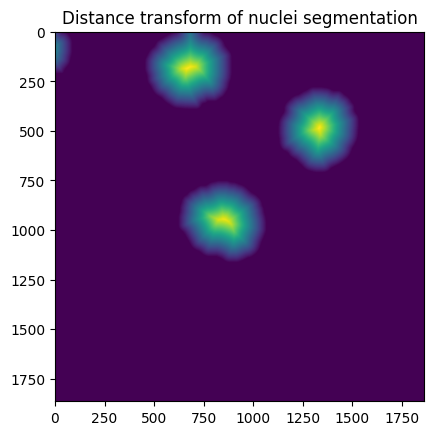

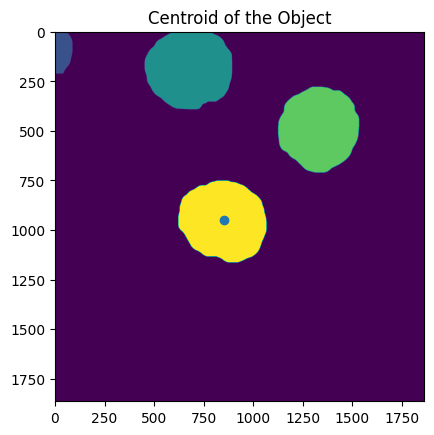

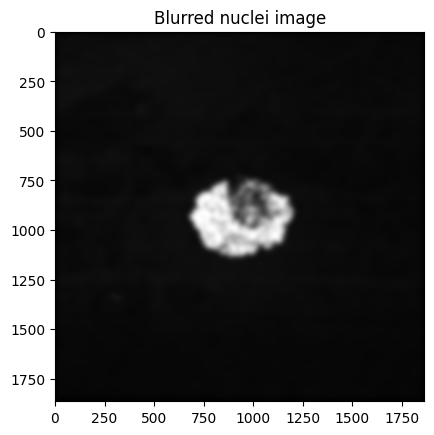

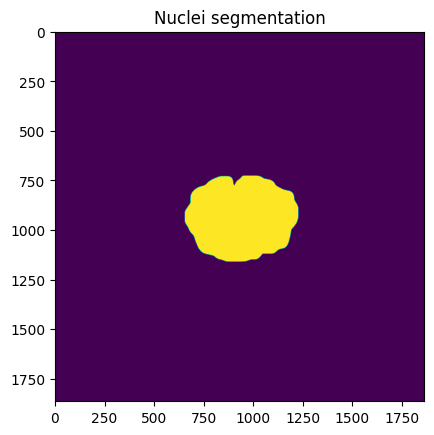

[[ 969  921]
 [ 936 1006]]


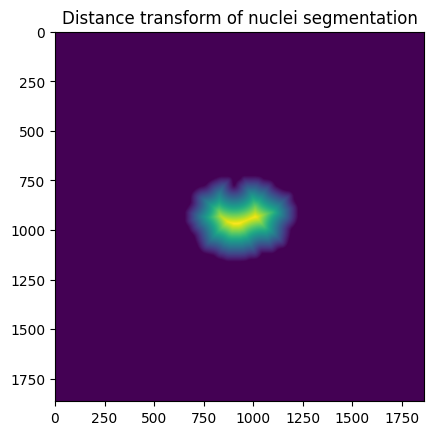

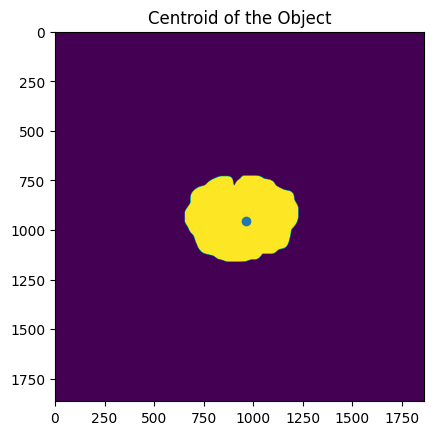

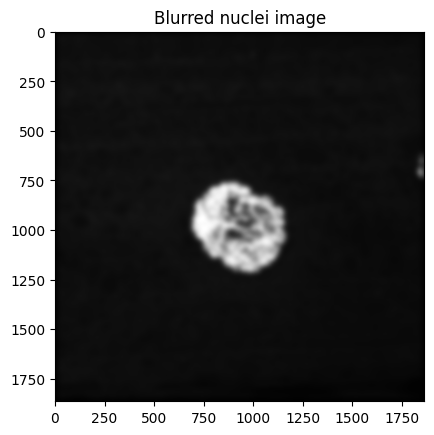

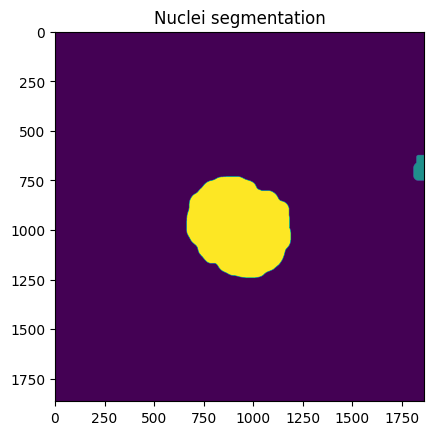

[[1009  960]]


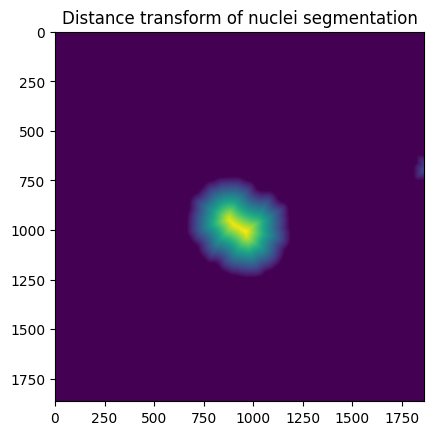

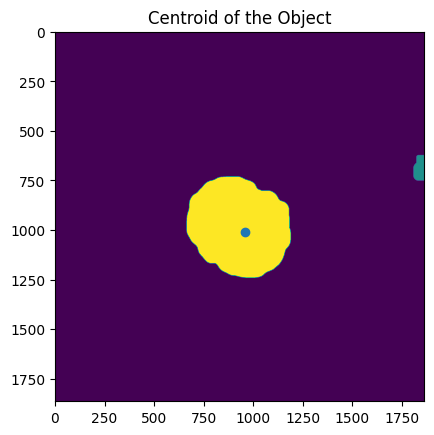

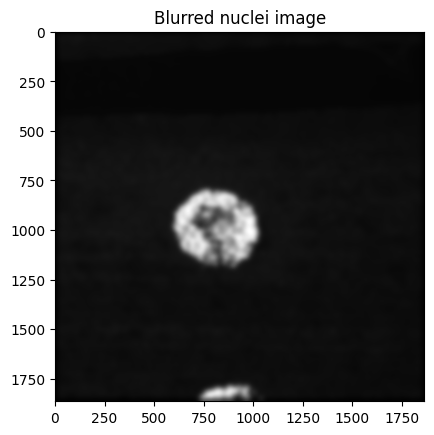

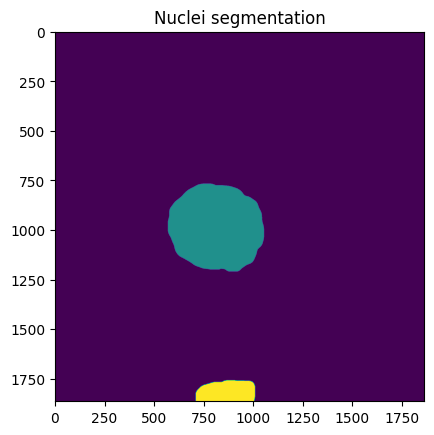

[[988 800]]


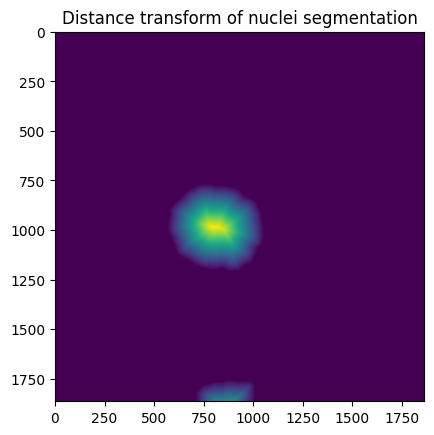

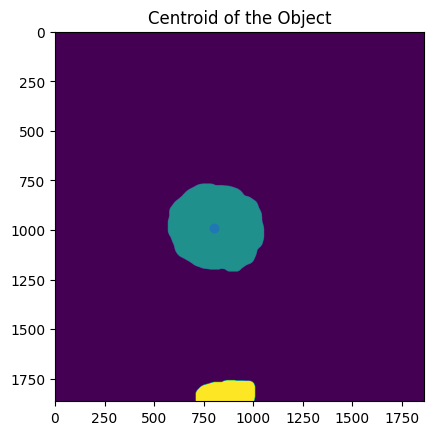

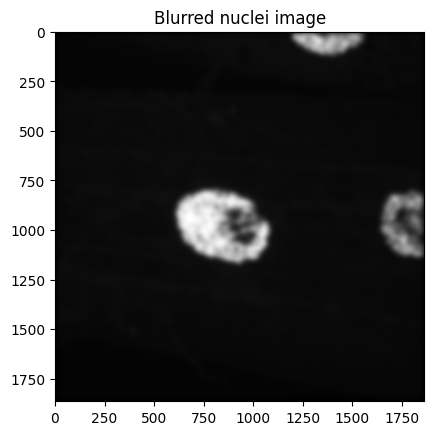

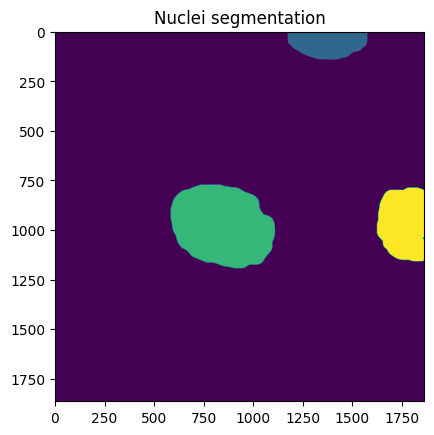

[[ 979  854]
 [ 970  805]
 [ 977 1749]]


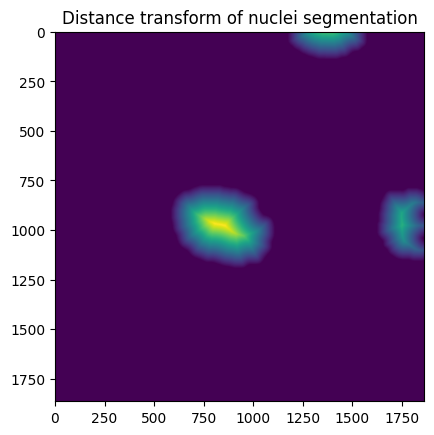

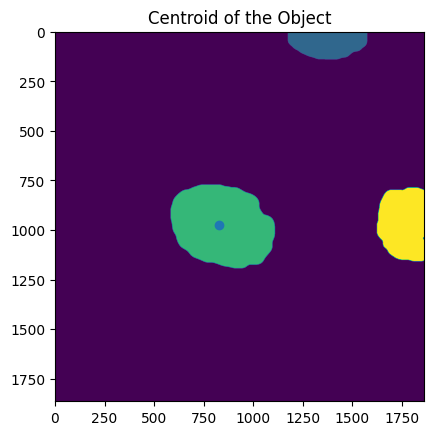

In [ ]:
y_centers = []
x_centers = []
for image in nuclei_im:
  im = imAdjust(image)

  n_image_mask = cv2.GaussianBlur(im,(85,85),0)
  plt.imshow(n_image_mask, cmap = 'gray')
  plt.title('Blurred nuclei image')
  plt.show()
  threshold = 50
  bin_n_image = n_image_mask > threshold

  dilated_image = binary_dilation(bin_n_image, structure=np.ones((35, 35)))
  filled_image = binary_fill_holes(dilated_image)

  seg_n_image = label(filled_image)
  plt.imshow(seg_n_image)
  plt.title('Nuclei segmentation')
  plt.show()

  #Loading in and pre-processing images above. Below, we are finding the centers of each nucleus in the image
  #The centers can be input manually by uncommenting the x_centers and y_centers variables below
  #If centers are input manually, be aware that the values you get from FIJI are in (row, column) form, where row
  #corresponds to the y_centers variable and column corresponds to x_centers (I know its not the best naming but here we are)

  distance = ndi.distance_transform_edt(seg_n_image)
  optima_window_size = 75
  coords = peak_local_max(distance,\
                        footprint=np.ones((optima_window_size, optima_window_size)))

  #Need to transpose the coordinates?
  mask = (coords[:, 0] >= 550) & (coords[:, 0] <= 1250) & (coords[:, 1] >= 550) & (coords[:, 1] <= 1250)
  print(coords)
  center_coords = coords[mask]
  center_original = np.mean(center_coords, axis=0)
  center = center_original[::-1]
  x_centers.append(int(center[1]))
  y_centers.append(int(center[0]))


  plt.imshow(distance)
  plt.title('Distance transform of nuclei segmentation')
  plt.show()
  # Display the image
  plt.imshow(seg_n_image)
  plt.scatter(y_centers[len(y_centers)-1], x_centers[len(x_centers)-1])
  plt.title("Centroid of the Object")
  plt.show()

#of course, you can also manually enter the x y values for the center of nuclei by uncommenting the codes below
#x_centers[0] = 250
#y_centers[0] = 250
#plt.imshow(nuclei_im[0])
#plt.scatter(y_centers[0], x_centers[0])
#plt.show()

## Automatically Calculating Nuclei Center for Confocal only

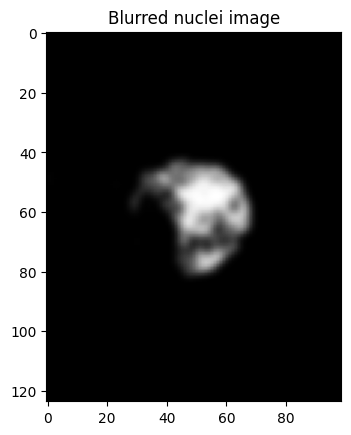

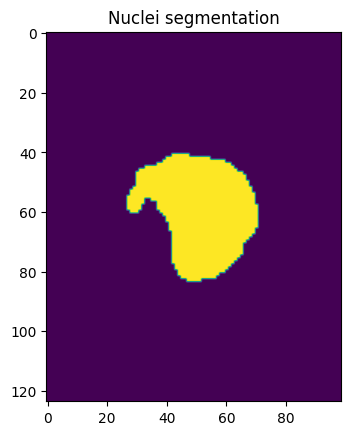

[[60 55]]


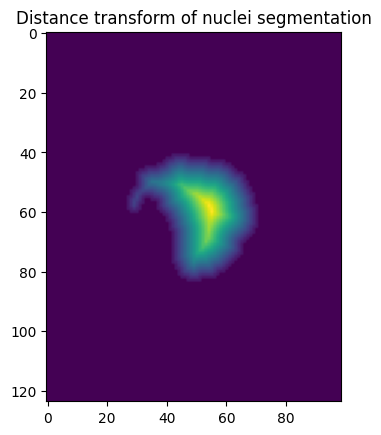

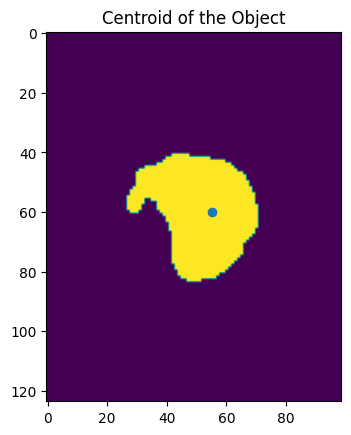

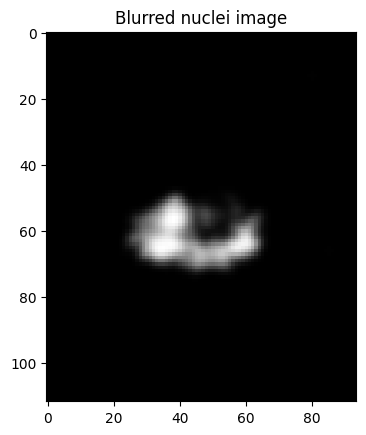

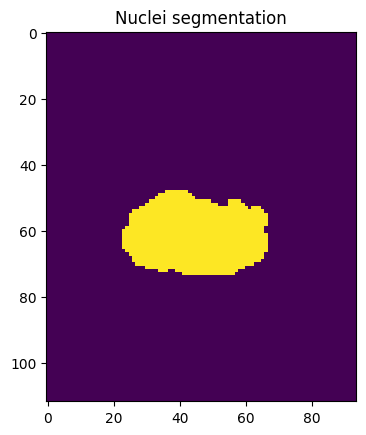

[[62 45]]


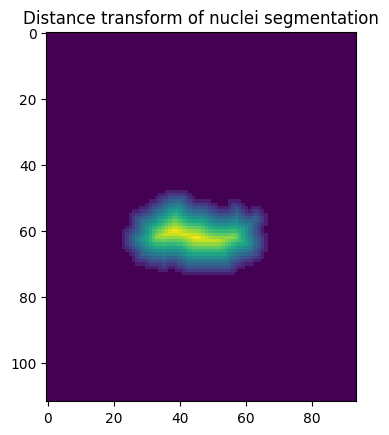

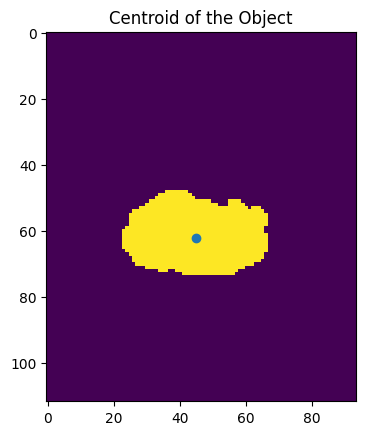

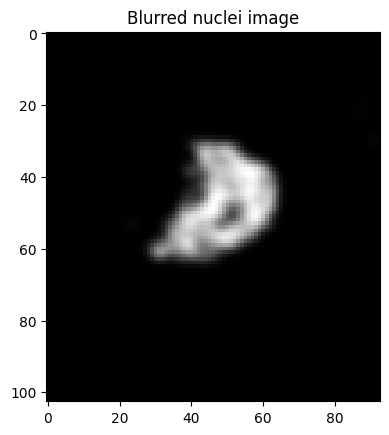

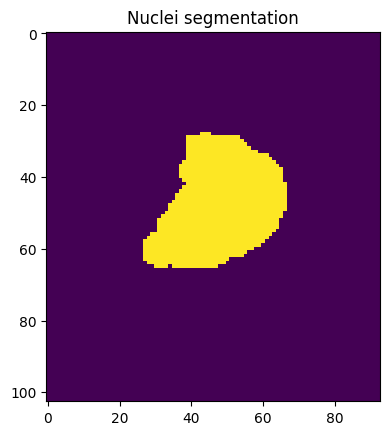

[[46 52]]


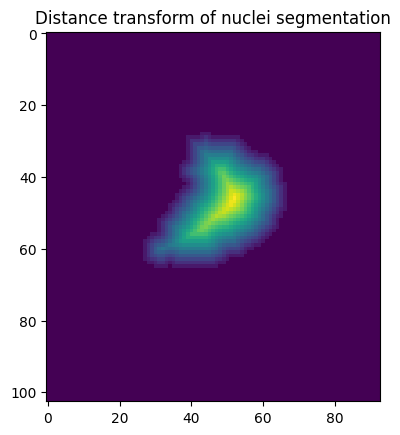

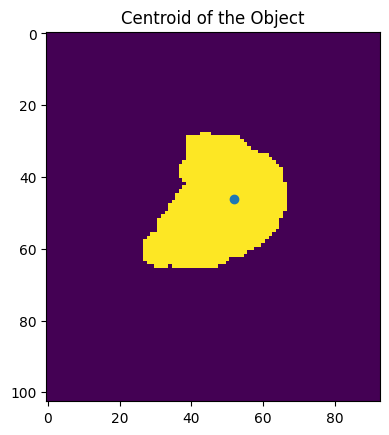

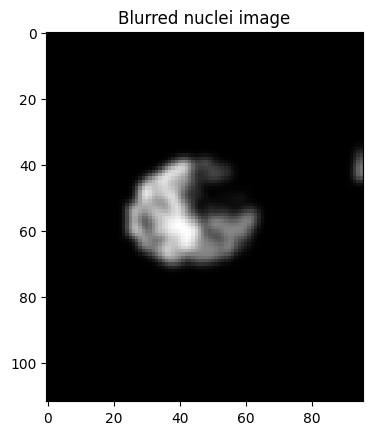

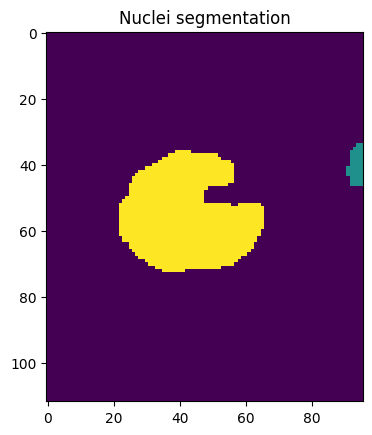

[[57 36]]


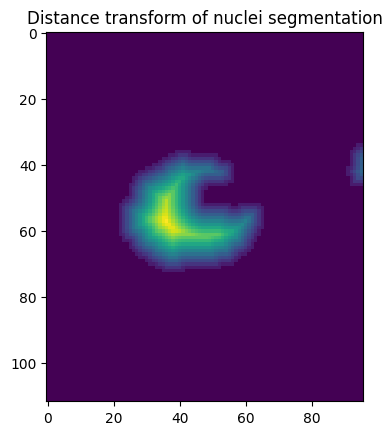

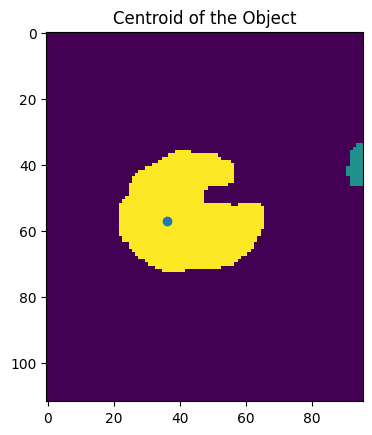

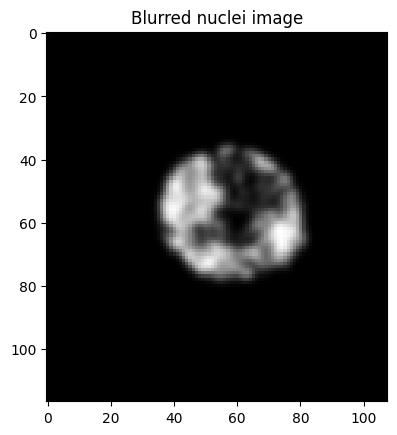

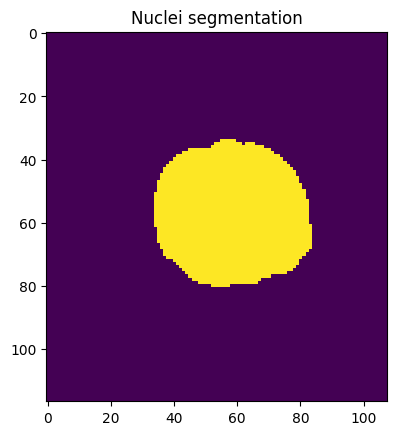

[[57 59]]


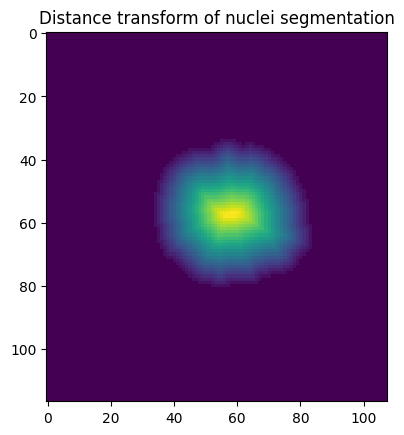

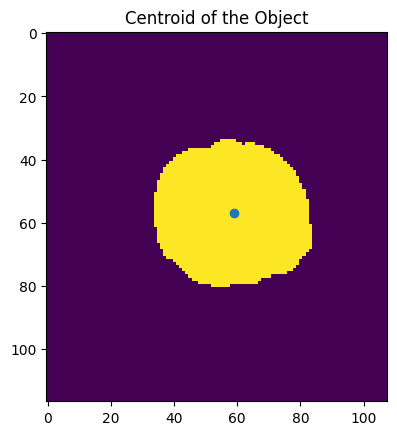

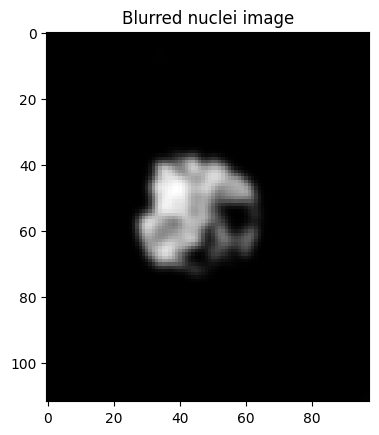

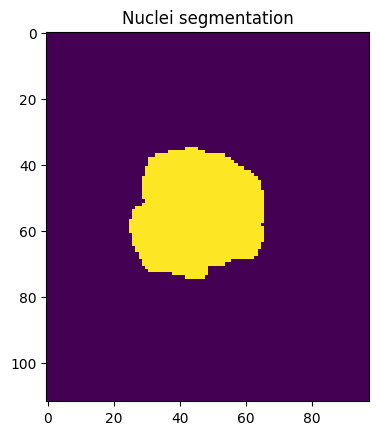

[[54 46]]


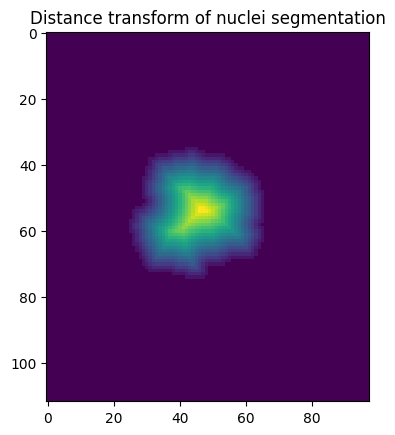

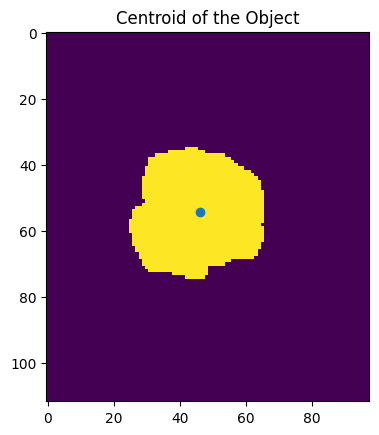

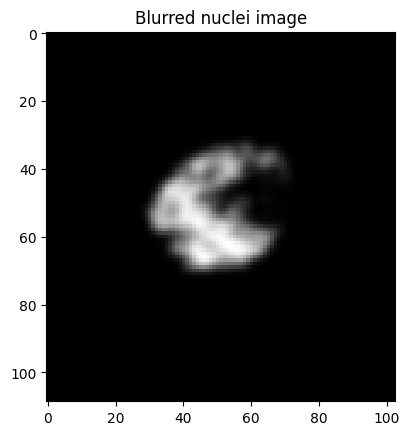

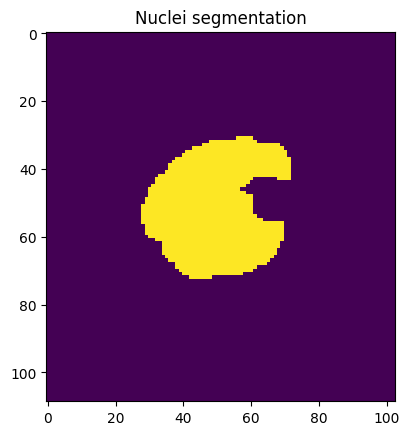

[[57 47]]


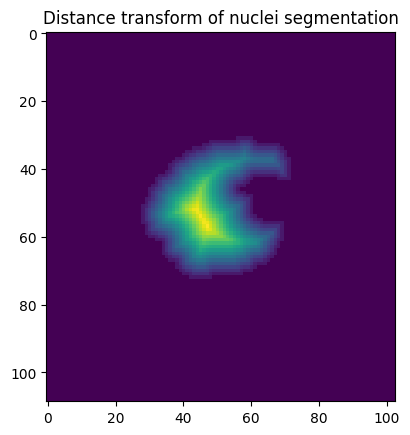

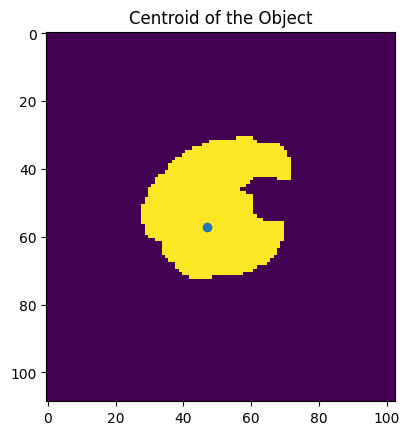

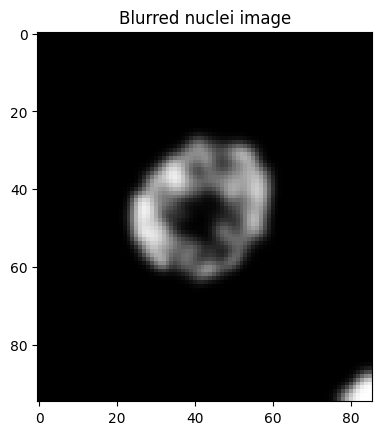

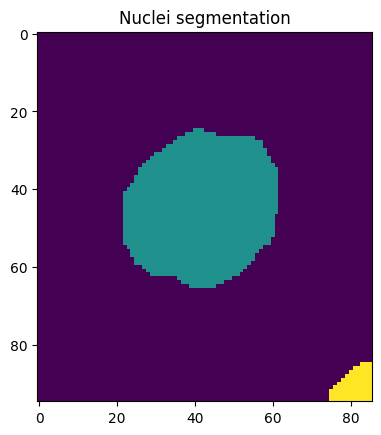

[[45 42]]


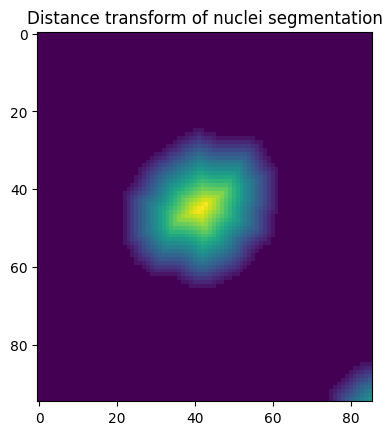

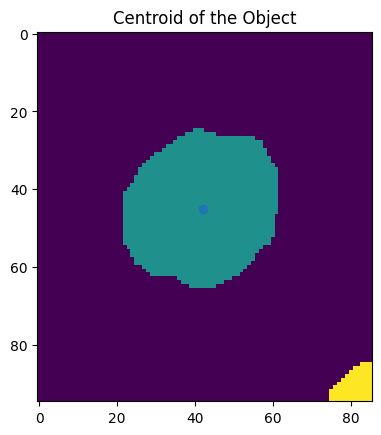

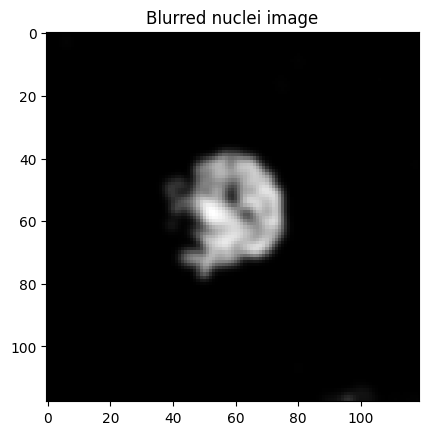

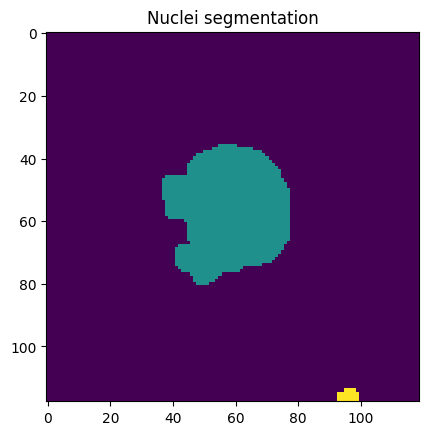

[[55 60]]


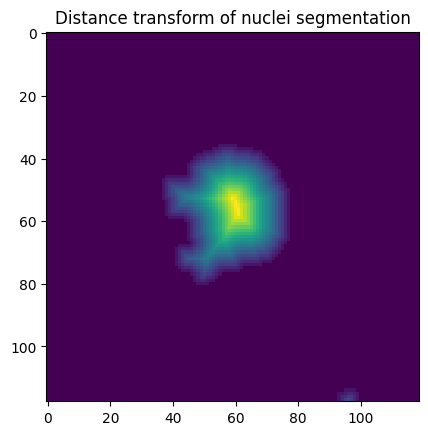

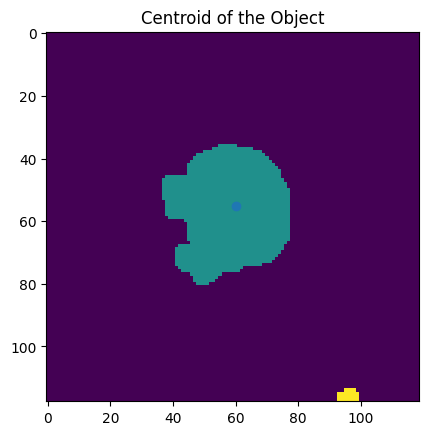

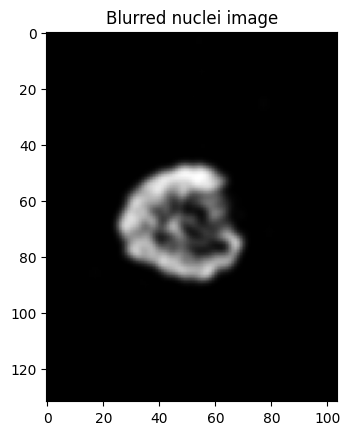

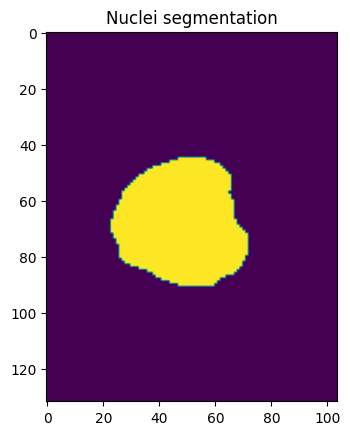

[[67 46]]


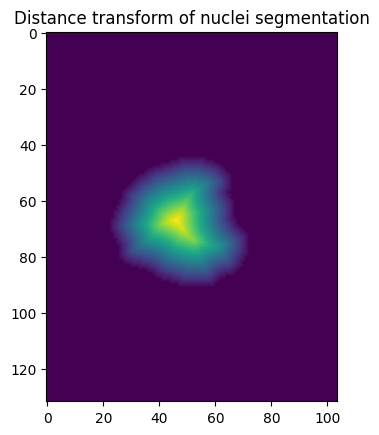

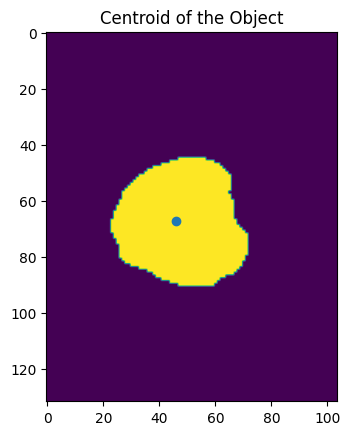

In [ ]:
y_centers = []
x_centers = []
for image in nuclei_im:
  im = imAdjust(image)

  n_image_mask = cv2.GaussianBlur(im,(7,7),0)
  plt.imshow(n_image_mask, cmap = 'gray')
  plt.title('Blurred nuclei image')
  plt.show()
  threshold = 20
  bin_n_image = n_image_mask > threshold

  dilated_image = binary_dilation(bin_n_image, structure=np.ones((3, 3)))
  filled_image = binary_fill_holes(dilated_image)

  seg_n_image = label(filled_image)
  plt.imshow(seg_n_image)
  plt.title('Nuclei segmentation')
  plt.show()

  #Loading in and pre-processing images above. Below, we are finding the centers of each nucleus in the image
  #The centers can be input manually by uncommenting the x_centers and y_centers variables below
  #If centers are input manually, be aware that the values you get from FIJI are in (row, column) form, where row
  #corresponds to the y_centers variable and column corresponds to x_centers (I know its not the best naming but here we are)

  distance = ndi.distance_transform_edt(seg_n_image)
  optima_window_size = 25
  coords = peak_local_max(distance,\
                        footprint=np.ones((optima_window_size, optima_window_size)))

  #Need to transpose the coordinates?
  mask = (coords[:, 0] >= 30) & (coords[:, 0] <= 70) & (coords[:, 1] >= 30) & (coords[:, 1] <= 70)
  center_coords = coords[mask]
  center_original = np.mean(center_coords, axis=0)
  center = center_original[::-1]
  x_centers.append(int(center[1]))
  y_centers.append(int(center[0]))


  plt.imshow(distance)
  plt.title('Distance transform of nuclei segmentation')
  plt.show()
  # Display the image
  plt.imshow(seg_n_image)
  plt.scatter(y_centers[len(y_centers)-1], x_centers[len(x_centers)-1])
  plt.title("Centroid of the Object")
  plt.show()

#of course, you can also manually enter the x y values for the center of nuclei by uncommenting the codes below
#x_centers[0] = 250
#y_centers[0] = 250
#plt.imshow(nuclei_im[0])
#plt.scatter(y_centers[0], x_centers[0])
#plt.show()

## Concentric Circle Analysis for Airyscans only

note: Depending on the image, the radii_list can be adjusted. Currently it says [x for x in range(30, 600, 30)], where the first number is the inner-most radius, second number is the outermost radius, and the last number means each iteration increment the radius by 30 pixels.

Also, the pixel_threshold variable may be adjusted. A higher threshold value will be less sensitive to microtubule signals.

Drawing concentric circles and calculating MT density. Writing measurements to an excel file named Concentric Circle Data.xlsx

[[0.3013508832698303, 0.35919607384903013, 0.498870535084004, 0.41848976711362035, 0.49184249745078046, 0.5592904428305161, 0.5879843486767024, 0.592763809613661, 0.5476695355702466, 0.45283229674872444, 0.46786736239690285, 0.440385029369253, 0.4544400124473111, 0.4309094241797376, 0.44764704447317705, 0.4331804595340772, 0.421251151925591, 0.4656681422189881, 0.4466502189836862]]
Desnties at radii [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570] for nucleus 1 are [0.3013508832698303, 0.35919607384903013, 0.498870535084004, 0.41848976711362035, 0.49184249745078046, 0.5592904428305161, 0.5879843486767024, 0.592763809613661, 0.5476695355702466, 0.45283229674872444, 0.46786736239690285, 0.440385029369253, 0.4544400124473111, 0.4309094241797376, 0.44764704447317705, 0.4331804595340772, 0.421251151925591, 0.4656681422189881, 0.4466502189836862]


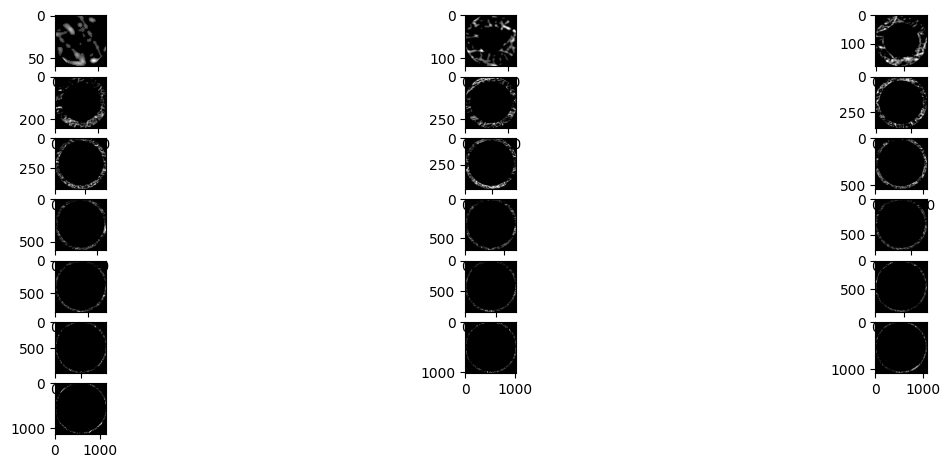

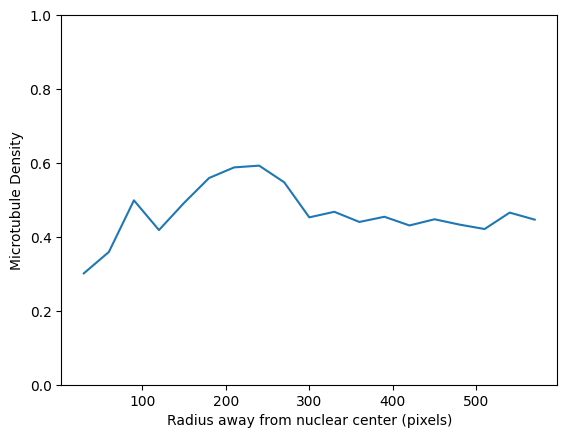

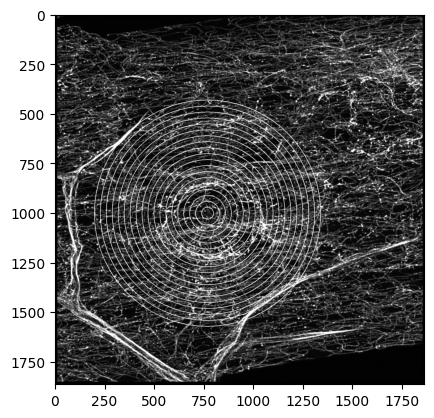

[[0.6480775891929338, 0.5072446833372283, 0.5475081180290837, 0.5590281278354673, 0.6419327006039689, 0.7016196413651263, 0.7998750067931091, 0.7272276994197839, 0.685106648372209, 0.6376857472719825, 0.5071873421982831, 0.5315988559830243, 0.48363461484058956, 0.5111943229725837, 0.4645044034056256, 0.42254774454103633, 0.4322325476703431, 0.4164927776989931, 0.38506464813356134]]
Desnties at radii [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570] for nucleus 1 are [0.6480775891929338, 0.5072446833372283, 0.5475081180290837, 0.5590281278354673, 0.6419327006039689, 0.7016196413651263, 0.7998750067931091, 0.7272276994197839, 0.685106648372209, 0.6376857472719825, 0.5071873421982831, 0.5315988559830243, 0.48363461484058956, 0.5111943229725837, 0.4645044034056256, 0.42254774454103633, 0.4322325476703431, 0.4164927776989931, 0.38506464813356134]


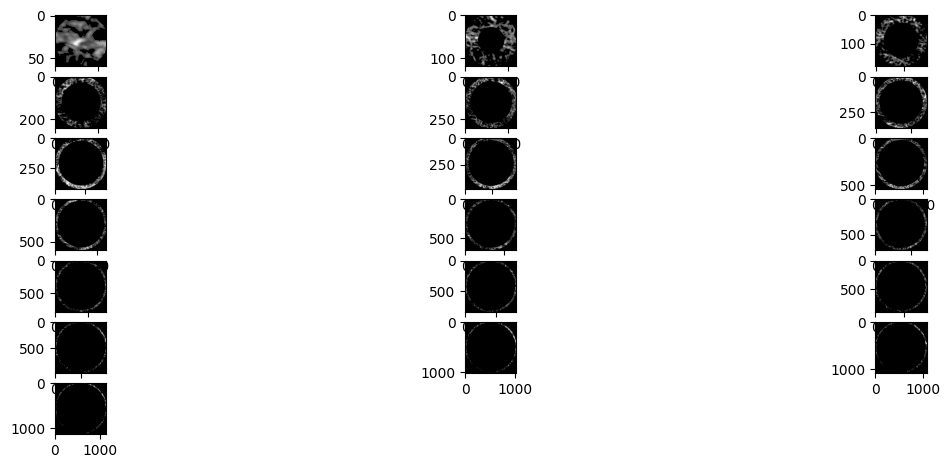

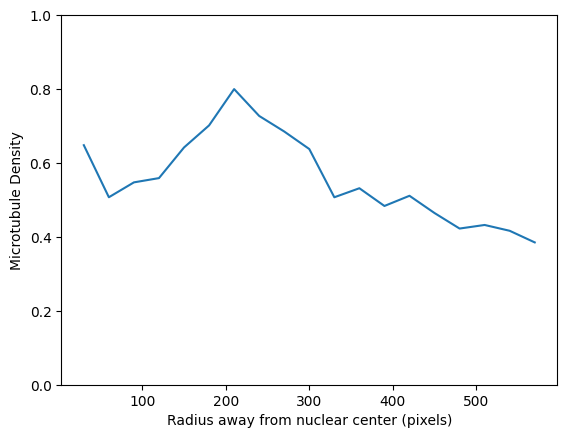

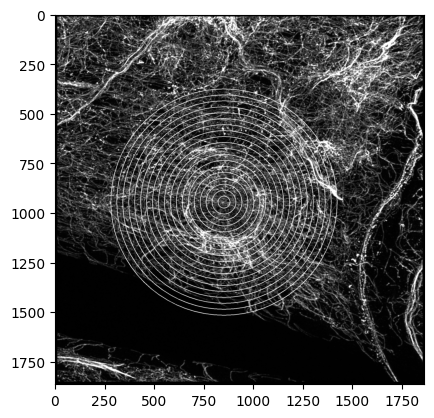

[[0.3553862140630412, 0.2042533302173405, 0.28406042637300577, 0.3636959370904325, 0.5150992234685073, 0.5224307474773443, 0.6192326503994348, 0.6738761262323695, 0.6548376366887032, 0.5929946743138058, 0.5763676148796499, 0.5104406925608144, 0.4867464426150669, 0.47492733509649376, 0.4204825449488912, 0.38585803271955643, 0.32770407835237136, 0.33560730095203445, 0.3400749708340505]]
Desnties at radii [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570] for nucleus 1 are [0.3553862140630412, 0.2042533302173405, 0.28406042637300577, 0.3636959370904325, 0.5150992234685073, 0.5224307474773443, 0.6192326503994348, 0.6738761262323695, 0.6548376366887032, 0.5929946743138058, 0.5763676148796499, 0.5104406925608144, 0.4867464426150669, 0.47492733509649376, 0.4204825449488912, 0.38585803271955643, 0.32770407835237136, 0.33560730095203445, 0.3400749708340505]


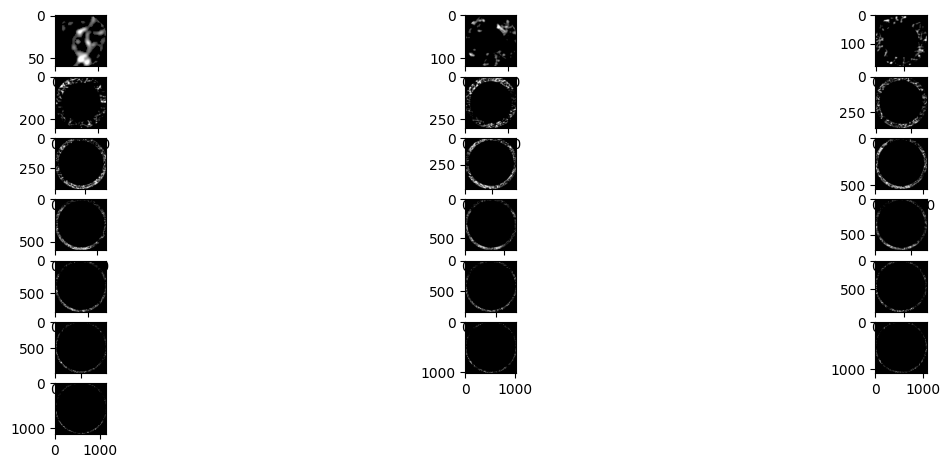

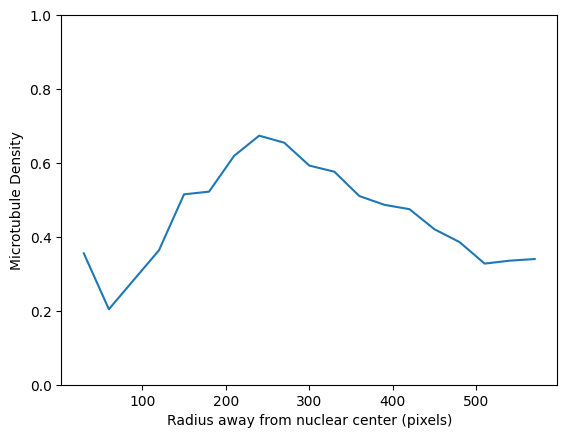

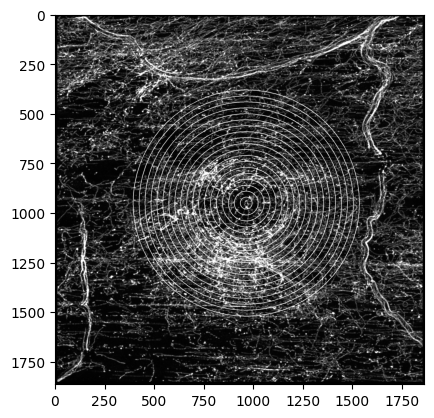

[[0.25320401801177694, 0.24982472540313158, 0.3070026824791755, 0.3486742615182982, 0.4039924699976469, 0.4336718298091137, 0.5663007445247541, 0.690056134723336, 0.6552118415034718, 0.5884697031767905, 0.5392358188857095, 0.4820094104622198, 0.487750714305921, 0.48072743460158684, 0.45566099875582444, 0.49981746412029116, 0.47515055399584233, 0.4387544721363168, 0.4298391569606212]]
Desnties at radii [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570] for nucleus 1 are [0.25320401801177694, 0.24982472540313158, 0.3070026824791755, 0.3486742615182982, 0.4039924699976469, 0.4336718298091137, 0.5663007445247541, 0.690056134723336, 0.6552118415034718, 0.5884697031767905, 0.5392358188857095, 0.4820094104622198, 0.487750714305921, 0.48072743460158684, 0.45566099875582444, 0.49981746412029116, 0.47515055399584233, 0.4387544721363168, 0.4298391569606212]


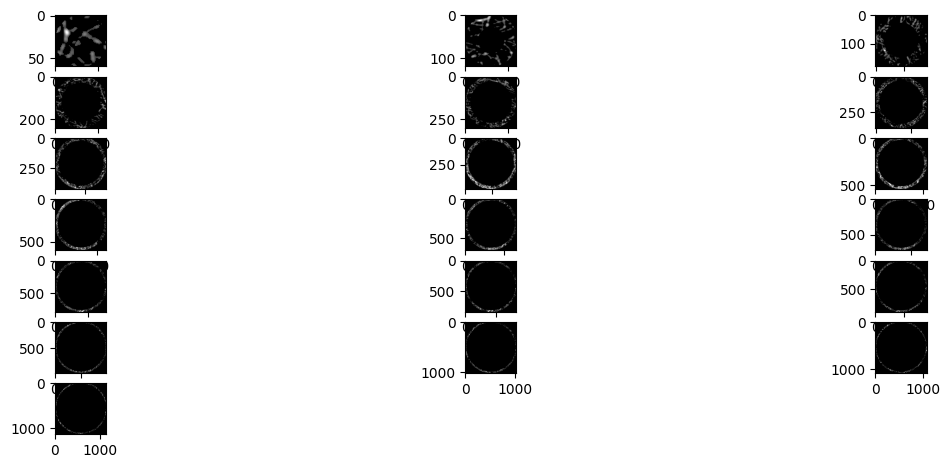

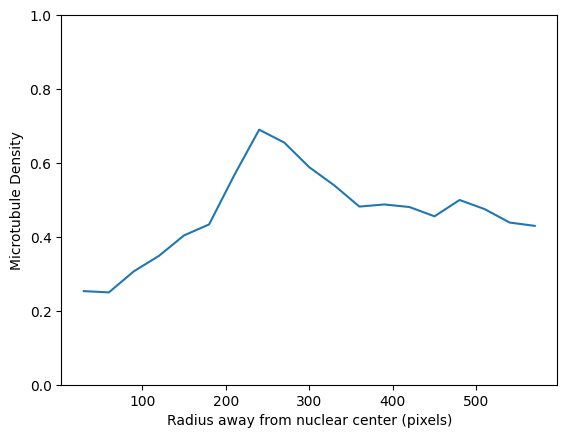

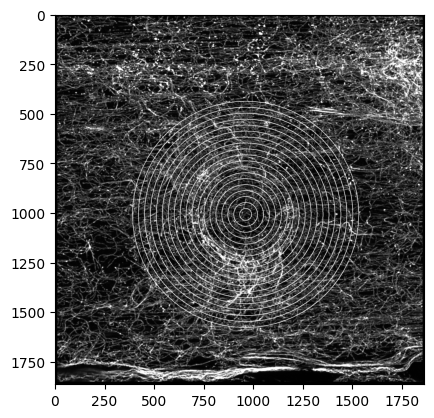

[[0.6317977138898511, 0.7035522318298668, 0.7259635747564591, 0.7240649258997883, 0.7625696133030042, 0.8324121087473488, 0.823161784685615, 0.7800132081701967, 0.6964783169098998, 0.6463074000968306, 0.5995118666891096, 0.5387797152258819, 0.48906616877422276, 0.5170860719055226, 0.4783854992559342, 0.4342414493348849, 0.4057028353442918, 0.4224425444181675, 0.3976322986593226]]
Desnties at radii [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570] for nucleus 1 are [0.6317977138898511, 0.7035522318298668, 0.7259635747564591, 0.7240649258997883, 0.7625696133030042, 0.8324121087473488, 0.823161784685615, 0.7800132081701967, 0.6964783169098998, 0.6463074000968306, 0.5995118666891096, 0.5387797152258819, 0.48906616877422276, 0.5170860719055226, 0.4783854992559342, 0.4342414493348849, 0.4057028353442918, 0.4224425444181675, 0.3976322986593226]


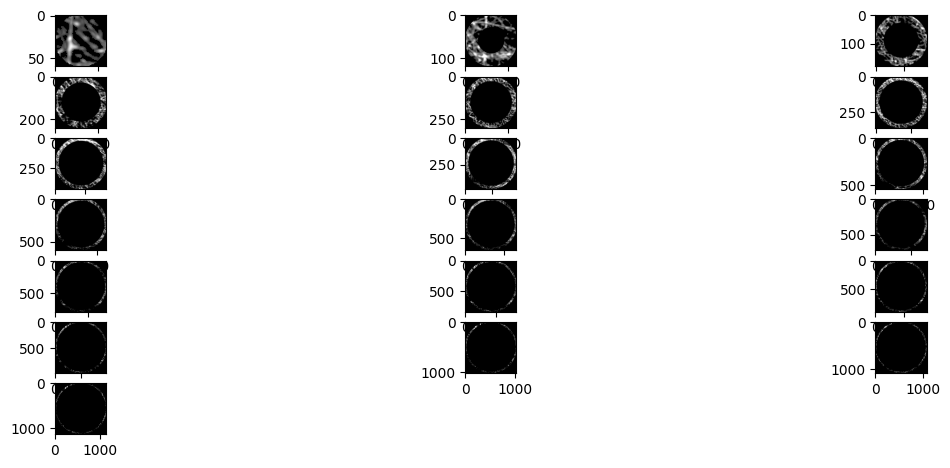

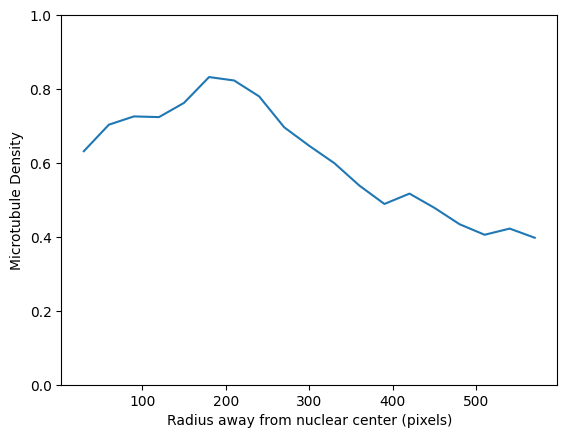

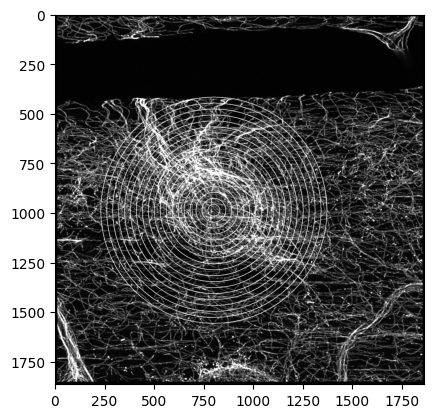

[[0.7585729130585382, 0.5828464594531433, 0.5644500917690244, 0.5705716302046577, 0.6879755274923524, 0.7919210746191915, 0.8342209662518342, 0.8002264257748007, 0.7401147561431957, 0.6256750214144725, 0.5299949503450597, 0.5577390288156964, 0.46896659028543947, 0.4721778522611223, 0.4261057305262131, 0.44340246879777306, 0.41347163584149504, 0.39970286823115636, 0.38640579876451125]]
Desnties at radii [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570] for nucleus 1 are [0.7585729130585382, 0.5828464594531433, 0.5644500917690244, 0.5705716302046577, 0.6879755274923524, 0.7919210746191915, 0.8342209662518342, 0.8002264257748007, 0.7401147561431957, 0.6256750214144725, 0.5299949503450597, 0.5577390288156964, 0.46896659028543947, 0.4721778522611223, 0.4261057305262131, 0.44340246879777306, 0.41347163584149504, 0.39970286823115636, 0.38640579876451125]


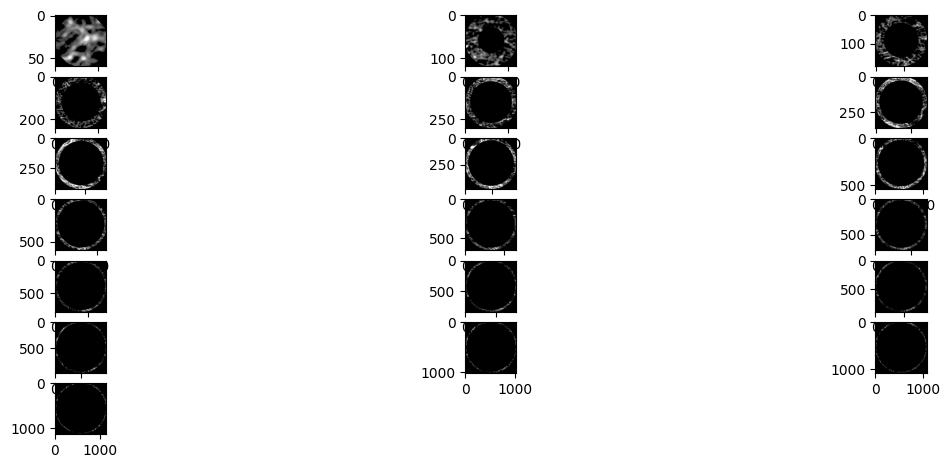

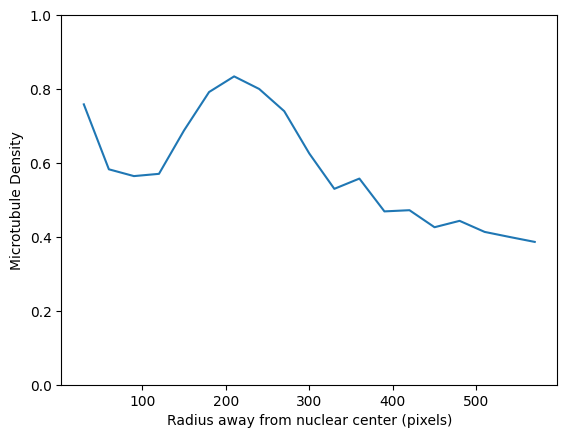

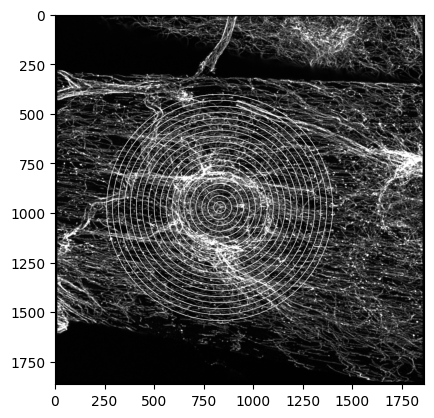

NameError: name 'dfo' is not defined

In [ ]:
radii_list = [x for x in range(30, 600, 30)]
df = pd.DataFrame(radii_list, columns = ['radius'])
for num, im in enumerate(micro_im):
  im = imAdjust(im)
  pixel_threshold = 50
  #List to determine radii in pixels for analysis
  total_densities = []
  #for nucleus in range(len(y_centers)): #loop through num of nuclei found in image
  count = 1
  densities = []
  plt.figure(figsize = (15,15))
  for i in range(len(radii_list)): #loop through each radius
      radius = radii_list[i]
      if i == 0:
        #adjust if you adjust the values in the radii list
        prev_rad = 0
      else:
        prev_rad = radii_list[i-1]
      square = im[x_centers[num]-radius:x_centers[num]+radius,y_centers[num]-radius:y_centers[num]+radius].astype(np.float32)
      #cropping circle and ring
      height,width = square.shape
      mask = Image.new('L', [height,width] , 0)
      mask1 = Image.new('L', [height,width] , 0)

      #drawing outer ring
      draw = ImageDraw.Draw(mask)
      draw.pieslice([(0,0), (height,width)], 0, 360, fill = 255, outline = "white")

      #drawing inner ring
      draw = ImageDraw.Draw(mask1)
      diff = radius - prev_rad
      draw.pieslice([(diff,diff), (height - diff,width - diff)], 0, 360, fill = 255, outline = "white")

      #cropping image based on the two rings drawn
      np_mask = np.array(mask)
      p_np_mask = np.array(mask1)
      ring = np.zeros(square.shape)
      for i in range(np_mask.shape[0]):
        for j in range(np_mask.shape[1]):
          if np_mask[i][j] == 255 and p_np_mask[i][j] == 0:
            ring[i][j] = square[i][j]

      #Calculate Density
      microtubules = 0
      total_pixels = 0
      m_im = np.zeros(ring.shape)
      for x in range(ring.shape[0]):
          for y in range(ring.shape[1]):
              if ring[x,y] > pixel_threshold:
                  microtubules += 1
                  m_im[x,y] = ring[x,y]
              if ring[x,y] > 0:
                total_pixels += 1
      plt.subplot(len(radii_list), 3, count)
      plt.imshow(m_im, cmap = 'gray')
      count += 1
      density = microtubules/total_pixels
      densities.append(density)
      #print('density of microtubules at nuclei',nucleus+1,'with radius',radius,'pixels is',density)
  total_densities.append(densities)
  #print('-----------------------------')

  #Printing out and plotting results
  #print(len(total_densities))
  print(total_densities)
  df[file_name[num]] = total_densities[0]
  #df.to_excel(dfo, index = False)
  plt.figure()
  n = 1
  for d in total_densities:
    plt.plot(radii_list, d)
    plt.ylim([0, 1])
    plt.xlabel("Radius away from nuclear center (pixels)")
    plt.ylabel("Microtubule Density")
    print("Desnties at radii", radii_list, "for nucleus", n, "are", d)
    n+=1

  #Displaying the concentric circles onto the image
  im_copy = im.copy()
  for nucleus in range(len(y_centers)):
    for radius in radii_list:
      cv2.circle(im_copy, (y_centers[num], x_centers[num]), radius, (255,255,255), 2)

  plt.figure()
  plt.imshow(im_copy, cmap = 'gray')
  plt.show()
df['Average'] = df.iloc[:, 1:].mean(axis=1)
df.to_excel(dfo, index = False, sheet_name = 'C.C. MT Densities')

dfi = pd.read_excel(dfo)
average = [x for x in list(dfi['Average'])]
plt.plot(radii_list, average)
plt.ylim([0, 1])
plt.xlabel("Radius away from nuclear center (pixels)")
plt.ylabel("Microtubule Density")
plt.title("Average Microtubule Density")
plt.show()


## Concentric Circle Analysis for Confocal only

Note: the pixel_threshold variable may be adjusted. A higher threshold value will be less sensitive to microtubule signals.

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40] for nucleus 1 are [0.44047619047619047, 0.35064935064935066, 0.6217616580310881, 0.638733705772812, 0.7167630057803468, 0.6662777129521587, 0.5735735735735735, 0.5426829268292683]


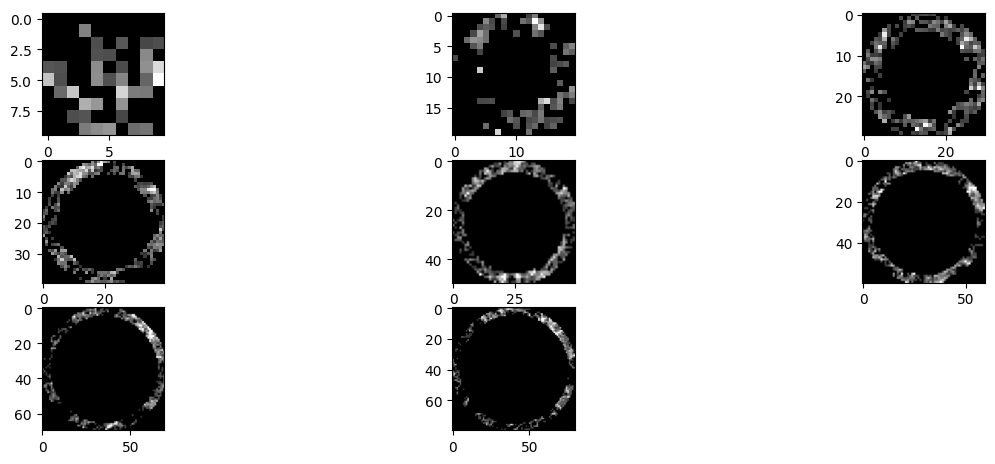

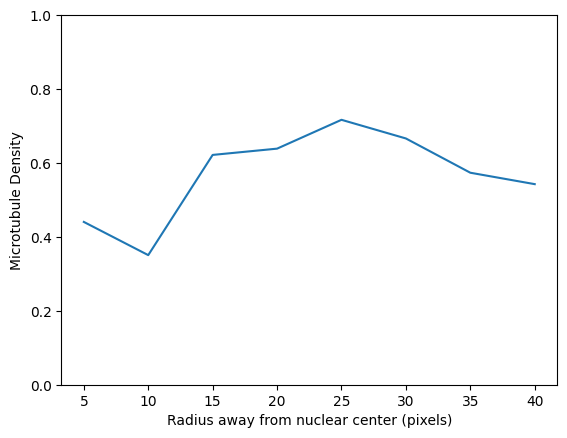

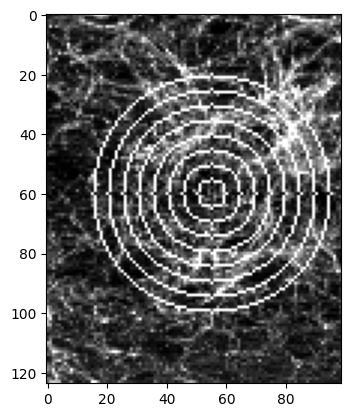

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40] for nucleus 1 are [0.7931034482758621, 0.5756302521008403, 0.6839378238341969, 0.6410256410256411, 0.6426512968299711, 0.5139211136890951, 0.44841269841269843, 0.35714285714285715]


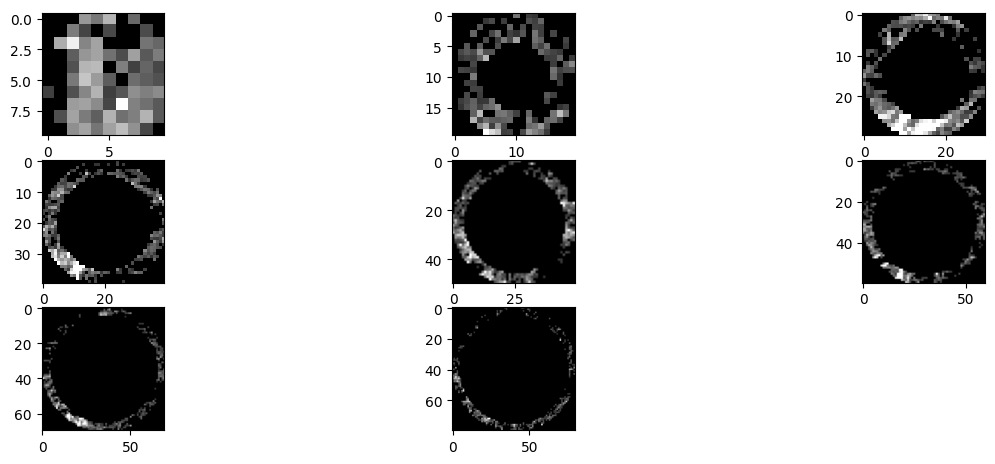

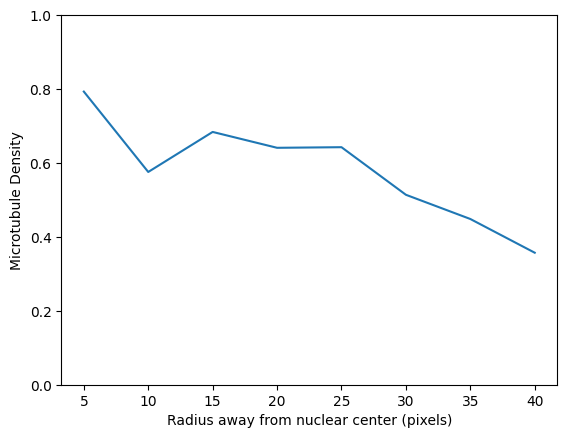

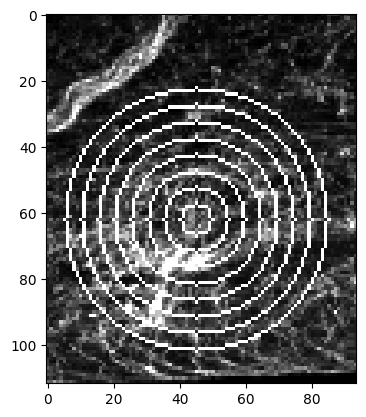

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40] for nucleus 1 are [0.08045977011494253, 0.22784810126582278, 0.5518134715025906, 0.6666666666666666, 0.5765895953757225, 0.4852420306965762, 0.374749498997996, 0.2858376511226252]


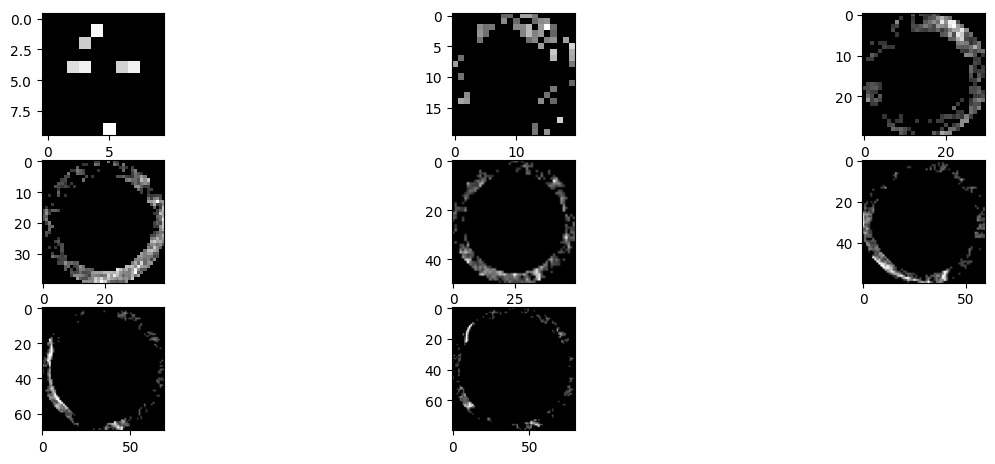

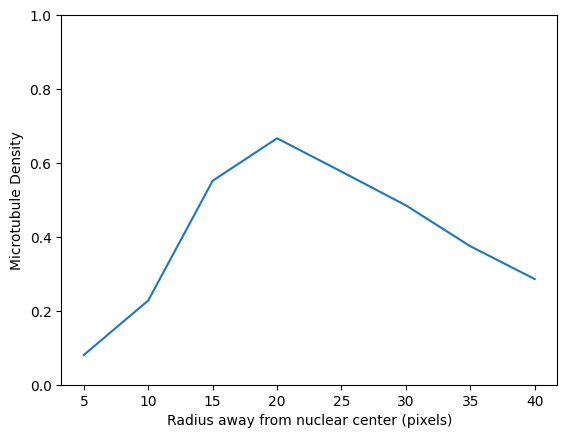

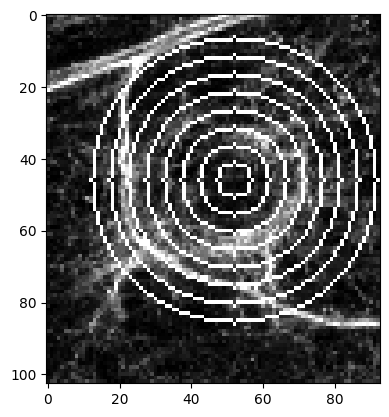

Desnties at radii [5, 10, 15, 20, 25, 30, 35] for nucleus 1 are [0.3448275862068966, 0.41596638655462187, 0.46475195822454307, 0.2902033271719039, 0.4491279069767442, 0.4077102803738318, 0.3231083844580777]


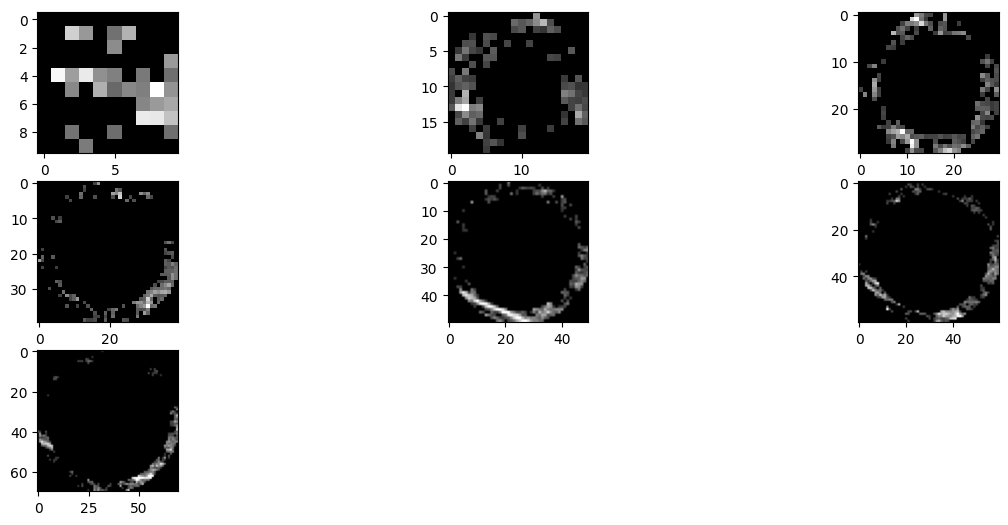

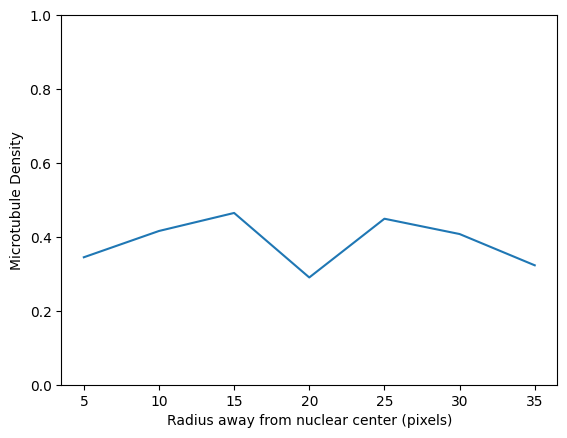

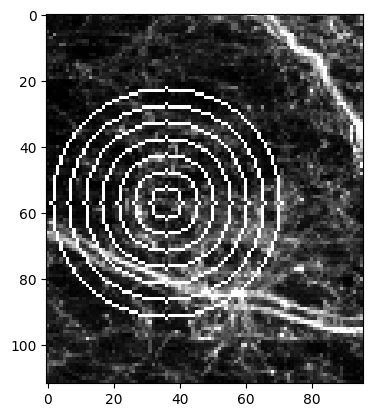

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40, 45] for nucleus 1 are [0.3058823529411765, 0.38362068965517243, 0.40105540897097625, 0.5037037037037037, 0.8314121037463977, 0.6382730455075846, 0.4150559511698881, 0.29308836395450566, 0.28823981552651806]


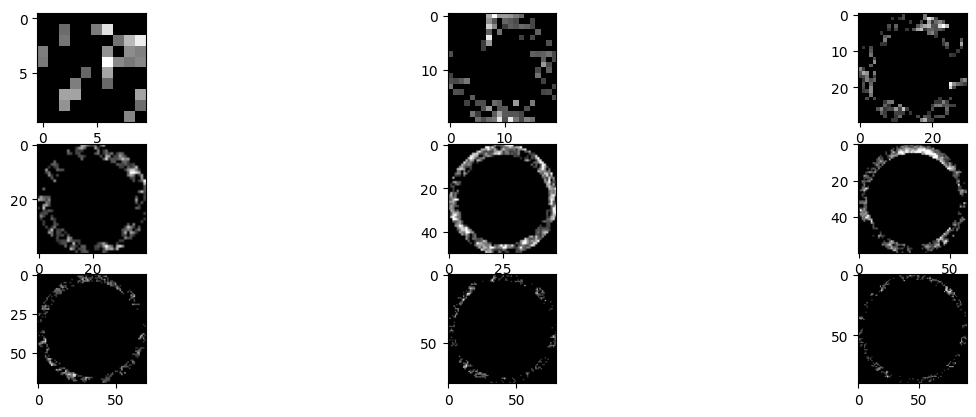

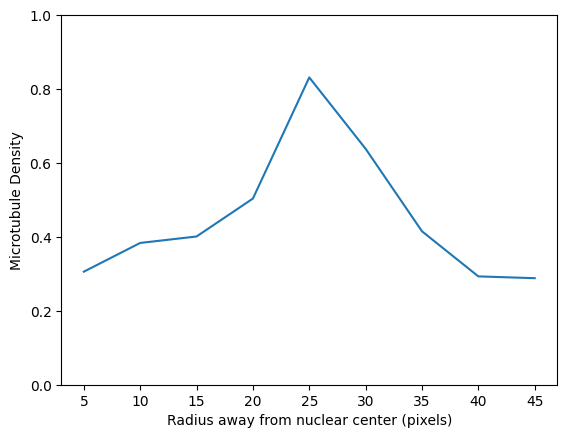

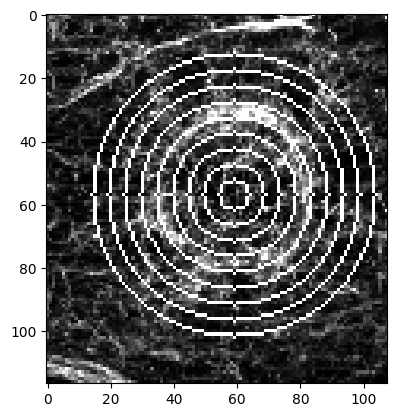

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40, 45] for nucleus 1 are [0.8390804597701149, 0.7184873949579832, 0.6062176165803109, 0.55, 0.4616519174041298, 0.5271867612293144, 0.48396793587174347, 0.4062229904926534, 0.3644067796610169]


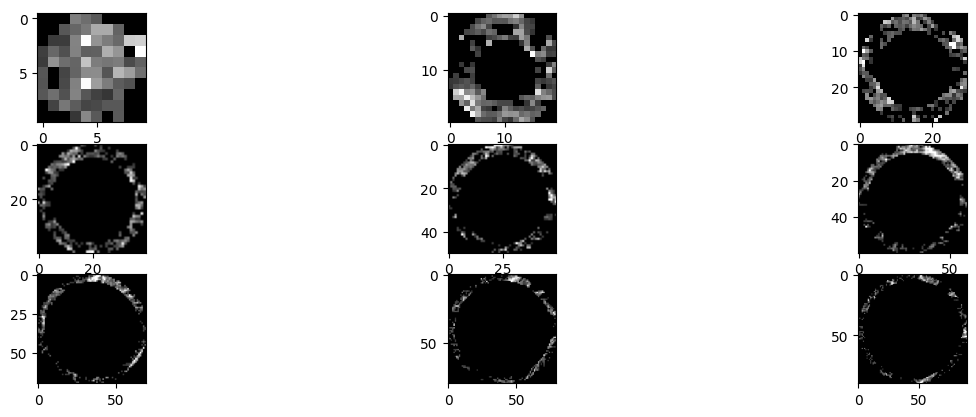

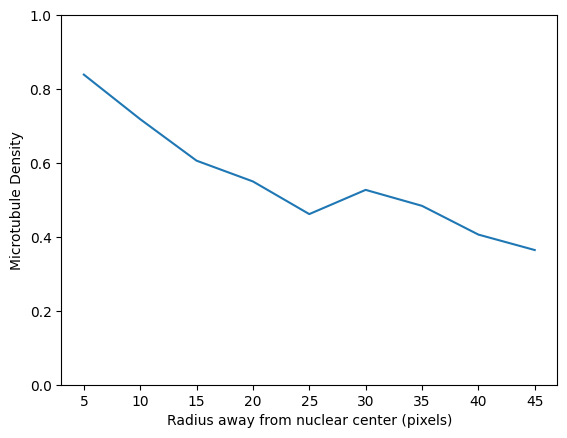

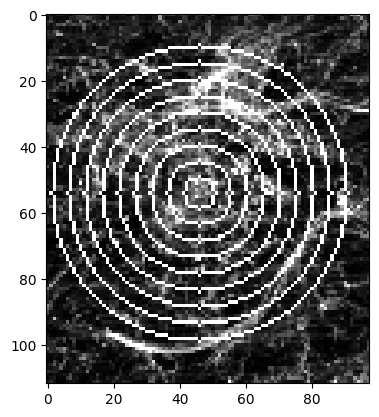

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40, 45] for nucleus 1 are [0.24050632911392406, 0.4495798319327731, 0.582901554404145, 0.5596330275229358, 0.5481049562682215, 0.47380675203725264, 0.3968095712861416, 0.39261168384879724, 0.339258114374034]


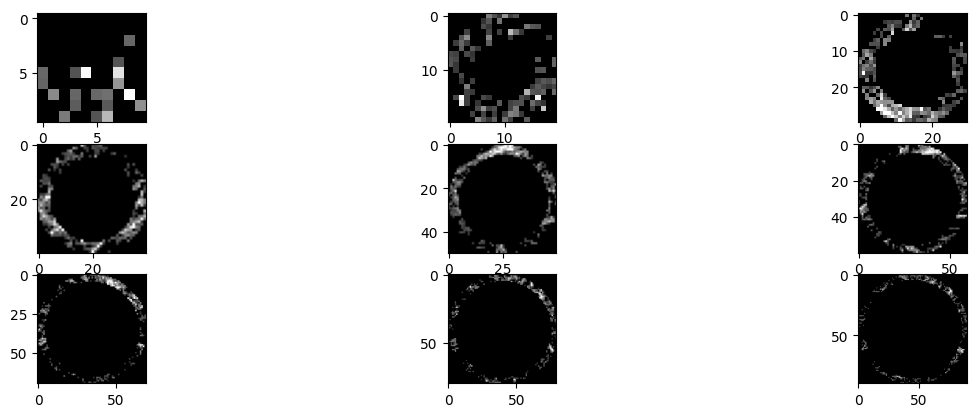

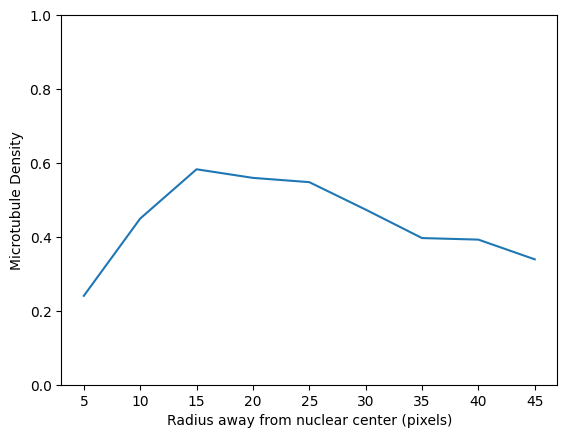

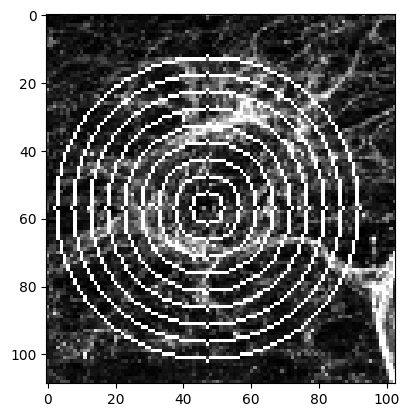

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40] for nucleus 1 are [0.4482758620689655, 0.3235294117647059, 0.6658031088082902, 0.7454212454212454, 0.32215743440233235, 0.3185530921820303, 0.4239350912778905, 0.4582608695652174]


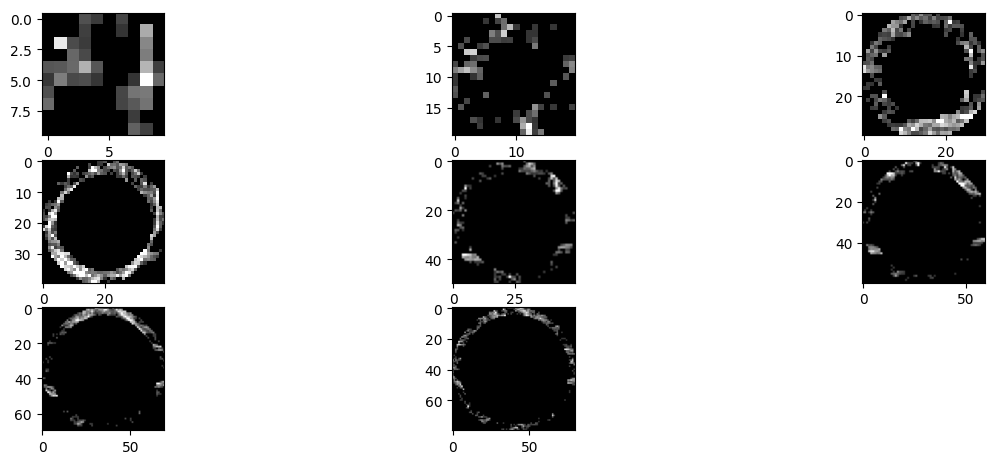

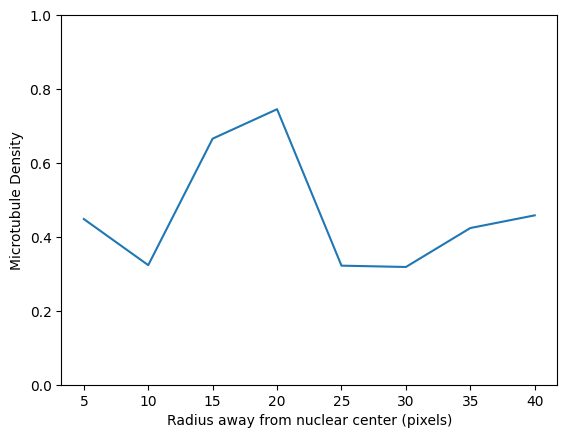

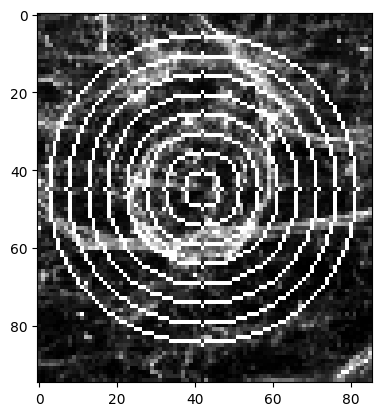

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] for nucleus 1 are [0.3333333333333333, 0.38396624472573837, 0.4464751958224543, 0.5512820512820513, 0.4818577648766328, 0.4462809917355372, 0.49798792756539234, 0.44587628865979384, 0.32021604938271603, 0.34139599170698]


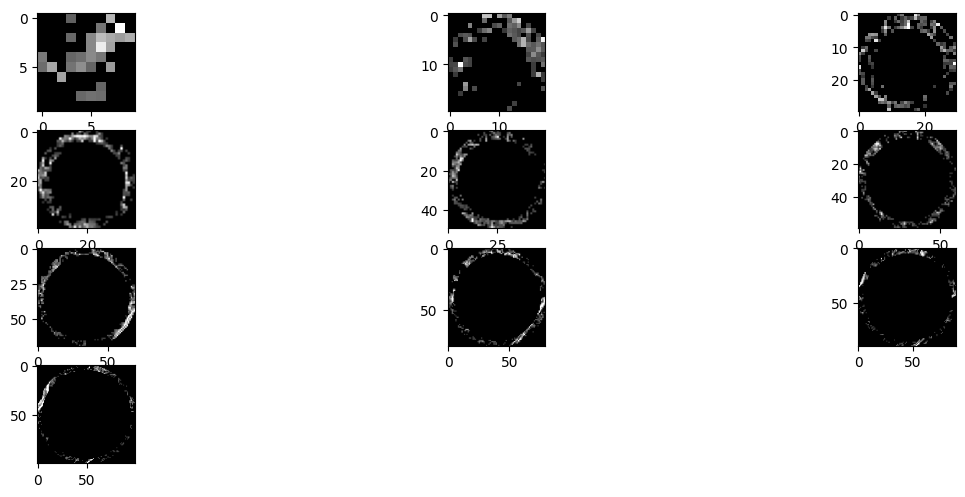

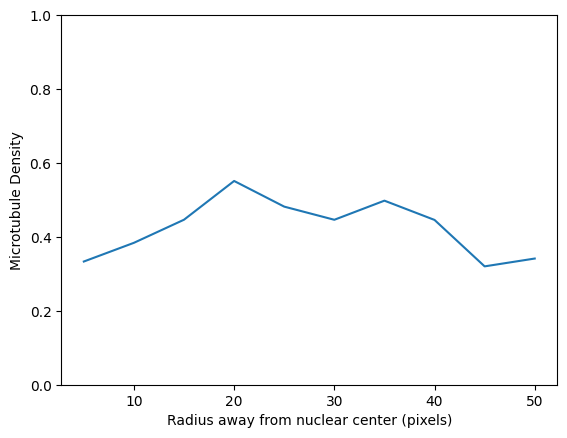

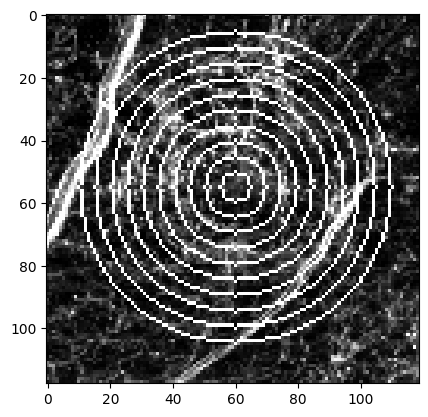

Desnties at radii [5, 10, 15, 20, 25, 30, 35, 40, 45] for nucleus 1 are [0.5172413793103449, 0.5672268907563025, 0.41578947368421054, 0.5129151291512916, 0.5703918722786647, 0.5066026410564226, 0.4580384226491405, 0.4772922022279349, 0.39908256880733944]


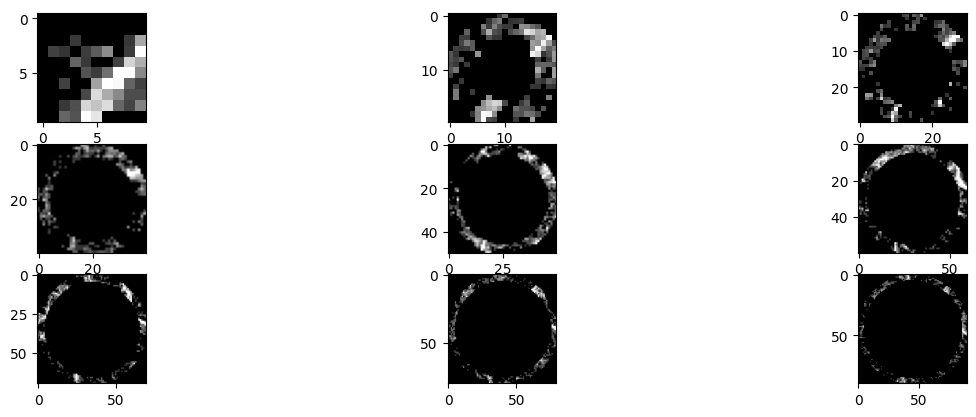

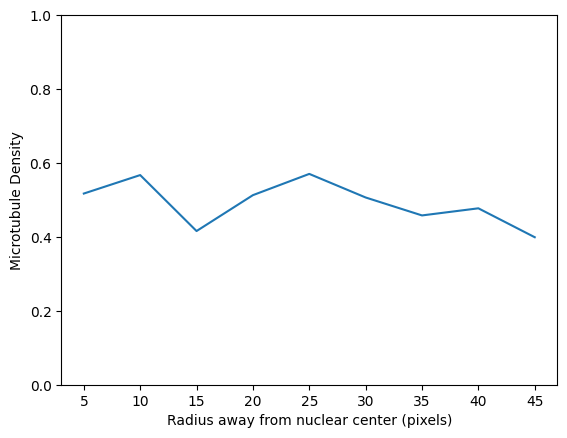

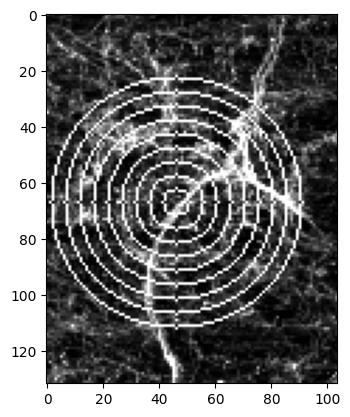

In [ ]:
pre_radius_list = [x for x in range(5, 60, 5)]
df = pd.DataFrame(pre_radius_list, columns = ['radius'])
for num, im in enumerate(micro_im):
  max_radius = min(im.shape[0] - x_centers[num], im.shape[1] - y_centers[num], x_centers[num], y_centers[num])
  smaller_dimension = min(im.shape[0], im.shape[1])
  radii_list = [x for x in range(5, max_radius, 5)]
  im = imAdjust(im)
  pixel_threshold = 50
  #List to determine radii in pixels for analysis
  total_densities = []
  #for nucleus in range(len(y_centers)): #loop through num of nuclei found in image
  count = 1
  densities = []
  plt.figure(figsize = (15,15))
  for i in range(len(radii_list)): #loop through each radius
      radius = radii_list[i]
      if i == 0:
        #adjust if you adjust the values in the radii list
        prev_rad = 0
      else:
        prev_rad = radii_list[i-1]
      square = im[x_centers[num]-radius:x_centers[num]+radius,y_centers[num]-radius:y_centers[num]+radius].astype(np.float32)
      #cropping circle and ring
      height,width = square.shape
      mask = Image.new('L', [height,width] , 0)
      mask1 = Image.new('L', [height,width] , 0)

      #drawing outer ring
      draw = ImageDraw.Draw(mask)
      draw.pieslice([(0,0), (height,width)], 0, 360, fill = 255, outline = "white")

      #drawing inner ring
      draw = ImageDraw.Draw(mask1)
      diff = radius - prev_rad
      draw.pieslice([(diff,diff), (height - diff,width - diff)], 0, 360, fill = 255, outline = "white")

      #cropping image based on the two rings drawn
      np_mask = np.array(mask)
      p_np_mask = np.array(mask1)
      ring = np.zeros(square.shape)
      for i in range(np_mask.shape[0]):
        for j in range(np_mask.shape[1]):
          if np_mask[i][j] == 255 and p_np_mask[i][j] == 0:
            ring[i][j] = square[i][j]

      #Calculate Density
      microtubules = 0
      total_pixels = 0
      m_im = np.zeros(ring.shape)
      for x in range(ring.shape[0]):
          for y in range(ring.shape[1]):
              if ring[x,y] > pixel_threshold:
                  microtubules += 1
                  m_im[x,y] = ring[x,y]
              if ring[x,y] > 0:
                total_pixels += 1
      plt.subplot(len(radii_list), 3, count)
      plt.imshow(m_im, cmap = 'gray')
      count += 1
      density = microtubules/total_pixels
      densities.append(density)
      #print('density of microtubules at nuclei',nucleus+1,'with radius',radius,'pixels is',density)
  total_densities.append(densities)
  #print('-----------------------------')

  #Printing out and plotting results
  #print(len(total_densities))
  df[file_name[num]] = pd.Series(total_densities[0])
  #df.to_excel(dfo, index = False)
  plt.figure()
  n = 1
  for d in total_densities:
    plt.plot(radii_list, d)
    plt.ylim([0, 1])
    plt.xlabel("Radius away from nuclear center (pixels)")
    plt.ylabel("Microtubule Density")
    print("Desnties at radii", radii_list, "for nucleus", n, "are", d)
    n+=1

  #Displaying the concentric circles onto the image
  im_copy = im.copy()
  for nucleus in range(len(y_centers)):
    for radius in radii_list:
      cv2.circle(im_copy, (y_centers[num], x_centers[num]), radius, (255,255,255), 1)

  plt.figure()
  plt.imshow(im_copy, cmap = 'gray')
  plt.show()
df['Average'] = df.iloc[:, 1:].mean(axis=1)
df.to_excel(dfo, index = False, sheet_name = 'C.C. MT Densities')
